In [1]:
import torch,gc
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.models import convnext_large, ConvNeXt_Large_Weights
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import timm
from PIL import Image
import glob
import csv
import random
import numpy as np
import os
import pandas as pd
import wandb
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve,auc,balanced_accuracy_score,accuracy_score,cohen_kappa_score,matthews_corrcoef,f1_score
from sklearn.preprocessing import label_binarize
from base_model import InstanceClassifier, AttDual, DSMILNet,TopkHeadAttention,CF_Transformer
import datetime, copy
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Wed Jan 11 10:32:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:05:00.0 Off |                  N/A |
| 45%   60C    P2    74W / 250W |  10336MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  On   | 00000000:06:00.0 Off |                  N/A |
| 44%   

In [2]:
device = torch.device("cuda:3")
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(20221218)


gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=False))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [24]:
import numpy as np

type(np.mean([0,1,2,3,4,5,6]))

numpy.float64

In [4]:
wandb.init(project="DSMIL_3C", name="DSMILATT_seed20230110_CNT_VIG_VAN")
# wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: u2coldplay. Use `wandb login --relogin` to force relogin


In [3]:

def get_working_df(feats_files,metadata_file):
    """
    Collects the features files from the files in the given path.
    """
    metadata = pd.read_csv(metadata_file)
    metadata = metadata[metadata["diagnosis"]!="unsure"]
    # metadata['label'] = metadata['diagnosis'].apply(lambda x: 0 if x =='normal' else (2 if x == 'scc' or x=='plep' or x== 'mb bowen_bowen_plep' else 1))

    labels = []
    sets = []
    files = []
    for file in feats_files:
          bag_name = os.path.basename(file).split('.')[0]
          if bag_name in metadata["image_nr"].values:
           
      #     print(metadata.loc[metadata["image_nr"] == bag_name, 'label'].values)
            bag_label = metadata.loc[metadata["image_nr"] == bag_name, 'label'].values[0]
            bag_set = metadata.loc[metadata["image_nr"] == bag_name, 'set'].values[0]
            labels.append(bag_label)
            sets.append(bag_set)
            files.append(file)


    df = pd.DataFrame(files, columns=["feats_files"])
  
    df["labels"] = labels
    df["sets"] = sets
    return df


def get_feats_df(path,metadata_file):
    """
    Collects the features files from the files in the given path.
    """
    metadata = pd.read_csv(metadata_file)
    feats_files = sorted(glob.glob(os.path.join(path, "*.csv"), recursive=True))
    labels = []
    for file in feats_files:
          bag_name = os.path.basename(file).split('.')[0]
      

          bag_label = metadata.loc[metadata["image_nr"] == bag_name, 'label'].values[0]
          labels.append(bag_label)
    df = pd.DataFrame(feats_files, columns=["feats_files"])
  
    df["labels"] = labels
    return df
    
    

In [4]:
# metadata_file = "/restricteddata/skincancer_kuk/Scanned_WSI/metadata_label.csv"
working_file = "/restricteddata/skincancer_kuk/Scanned_WSI/metadata_workingfile_label.csv"


path = "/restricteddata/skincancer_kuk/tiles_20x/Features/ConvNext_20X"
path_vig = "/restricteddata/skincancer_kuk/tiles_20x/Features/VIG_20X"
path_van = "/restricteddata/skincancer_kuk/tiles_20x/Features/Van_20X"
path_combined = "/system/user/publicwork/yitaocai/Master_Thesis/Integrated_CVV20X_Dataset"


# df  =  get_feats_df(path, metadata_file)
# df = shuffle(df).reset_index(drop=True)
# df
# df_vig = get_feats_df(path_vig, metadata_file)
# df_vig = shuffle(df_vig).reset_index(drop=True)
# df_vig
# df_van = get_feats_df(path_van, metadata_file)
# df_van = shuffle(df_van).reset_index(drop=True)
# df_combined = get_feats_df(path_combined, metadata_file)
# df_combined = shuffle(df_combined[df_combined["labels"]!=2]).reset_index(drop=True)
# df_combined
feats_files_cnt = sorted(glob.glob(os.path.join(path,"*", "*.csv"), recursive=True))
feats_files_vig = sorted(glob.glob(os.path.join(path_vig,"*", "*.csv"), recursive=True))
feats_files_van = sorted(glob.glob(os.path.join(path_van,"*", "*.csv"), recursive=True))
feats_files_combined = sorted(glob.glob(os.path.join(path_combined, "*.csv"), recursive=True))


df  =  get_working_df(feats_files_cnt, working_file)
df = shuffle(df).reset_index(drop=True)
df
df_vig = get_working_df(feats_files_vig, working_file)
# df_vig = shuffle(df_vig).reset_index(drop=True)
df_vig
df_van = get_working_df(feats_files_van, working_file)
# df_van = shuffle(df_van).reset_index(drop=True)
df_combined = get_working_df(feats_files_combined, working_file)
# df_combined = shuffle(df_combined[df_combined["labels"]!=2]).reset_index(drop=True)
df_combined


,feats_files,labels,sets
0,/system/user/publicwork/yitaocai/Master_Thesis...,1,train
1,/system/user/publicwork/yitaocai/Master_Thesis...,1,train
2,/system/user/publicwork/yitaocai/Master_Thesis...,1,test
3,/system/user/publicwork/yitaocai/Master_Thesis...,0,train
4,/system/user/publicwork/yitaocai/Master_Thesis...,1,train
...,...,...,...
1103,/system/user/publicwork/yitaocai/Master_Thesis...,1,test
1104,/system/user/publicwork/yitaocai/Master_Thesis...,1,train
1105,/system/user/publicwork/yitaocai/Master_Thesis...,1,train
1106,/system/user/publicwork/yitaocai/Master_Thesis...,1,train


In [5]:
# w = df_combined['labels'].apply( lambda x: {0:round(1/3,2), 1:round(1/3,2), 2:(1-2*round(1/3,2))}[x] )
# df_combined['weights'] = df_combined['labels'].map({0: 16, 1: 6, 2: 86})
w = df_combined['labels'].map({0: 16, 1: 6, 2: 86})
weighted_spl_df = df_combined.sample(n=88, random_state= 8, weights=w, axis=0)
weighted_spl_df = weighted_spl_df.reset_index(drop=True)
print(weighted_spl_df)
print(weighted_spl_df['labels'].value_counts())

                                          feats_files  labels   sets
0   /system/user/publicwork/yitaocai/Master_Thesis...       2  train
1   /system/user/publicwork/yitaocai/Master_Thesis...       1  train
2   /system/user/publicwork/yitaocai/Master_Thesis...       1   test
3   /system/user/publicwork/yitaocai/Master_Thesis...       2   test
4   /system/user/publicwork/yitaocai/Master_Thesis...       1  train
..                                                ...     ...    ...
83  /system/user/publicwork/yitaocai/Master_Thesis...       0    val
84  /system/user/publicwork/yitaocai/Master_Thesis...       2  train
85  /system/user/publicwork/yitaocai/Master_Thesis...       2  train
86  /system/user/publicwork/yitaocai/Master_Thesis...       2  train
87  /system/user/publicwork/yitaocai/Master_Thesis...       2  train

[88 rows x 3 columns]
2    37
0    27
1    24
Name: labels, dtype: int64


In [6]:
def get_bag_feats(feats_df):
    feats= pd.read_csv(feats_df.iloc[0], header=None)
    feats = feats.to_numpy()
    label = feats_df.iloc[1]
    return feats, label

ls =df.labels.to_numpy()

# print(np.unique(ls, return_counts=True))
from collections import Counter

cw = Counter(ls)

cw



Counter({0: 297, 1: 741, 2: 70})

In [8]:

#Round1 Best search
# class Config:
#     grad_norm_clip = 0.8188
#     alpha = 0.5122
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.002578
#     weight_decay = 1e-5
#     batch_size = 128
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "sgd"
#     scheduler = "cosine"

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

#Round2 Best search
# class Config:
#     grad_norm_clip = 1.1064267106898578
#     alpha = 0.4332472392227129
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.0017927233496779717
#     weight_decay = 0.0001
#     batch_size = 40
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "adam"
#     scheduler = "cosine"

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

#SunnySearch
class Config:
    grad_norm_clip = 1.02580285460309
    alpha = 0.849435264741892
    in_size  = 3000
    classes = 3
    out_size = 3
    dropout = 0.3
    lr = 0.0203373691328209
    weight_decay = 0.0001
    batch_size = 420
    epochs = 50
    device = device
    optimizer = "SGD"
    scheduler = "cosine"
    betas = (0.5, 0.9)
    momentum = 0.9
    minlr = 0.000005
    thresh_prob = 0
    dataset= "CNT_VIG_VAN"
    w0 = 74
    w1 = 16
    w2 = 79
    split = "random"
    sd = random.randint(1, 9999)
    df = "df_combined"


    def __init__(self, **kwargs):
        for k,v in kwargs.items():
            setattr(self, k, v)


#MorningSearch

# class Config:
#     grad_norm_clip = 1.02580285460309
#     alpha = 0.7893775434808594
#     in_size  = 2000
#     classes = 3
#     out_size = 3
#     dropout = 0.7
#     lr = 0.020319308924998204
#     weight_decay = 0.00001
#     # batch_size = 40
#     epochs = 50
#     device = torch.device("cuda:0")
#     optimizer = "SGD"
#     scheduler = "cosine"
    # betas = (0.5, 0.9)
    # momentum = 0.9

#     def __init__(self, **kwargs):
#         for k,v in kwargs.items():
#             setattr(self, k, v)

In [9]:
config = Config()

In [7]:
sweep_config = {
    'method': 'bayes', #grid, random，bayes
    }
metric = {
    'name': 'valid_loss',
    'goal': 'minimize'   
    }
early_terminate = {
    'type': 'hyperband',
 
    'max_iter': 8,
    's': 2,

    }

sweep_config['metric'] = metric
sweep_config['early_terminate'] = early_terminate

In [9]:
# parameters_dict = {
#     'optimizer': {'values': ['Adam','Adamax','ASGD', 'SGD']},
#     # 'lambd':{ 'distribution': 'uniform','min': 0,'max': 0.1},
#     # 'eps':{ 'distribution': 'uniform','min': 0,'max': 0.1},
#     # 'factor':{ 'distribution': 'uniform','min': 0,'max': 1},
#     # 'patience':{ 'distribution': 'q_log_uniform_values','min': 0,'max': 10},
#     # 'alph':{'distribution': 'uniform','min': 0.5,'max': 1},
#     'scheduler': {'values': ['cosine',  'plateau']},
#     'dropout': {'distribution': 'uniform','min': 0,'max': 1},
#     'epochs': {'value': 2},
#     'lr': { 'distribution': 'uniform','min': 0,'max': 0.1},
#     'weight_decay':{ 'distribution': 'uniform','min': 0,'max': 0.1},

#     'alpha': {'distribution': 'uniform','min': 0.5,'max': 1},
#     'grad_norm_clip': {'distribution': 'normal','mu': 1,'sigma': 0.1},   
#     'device': {'values': ['cuda:0']},        
#     'in_size': {'values': [1000]},
#     'classes': {'values': [3]},
#     'out_size': {'values': [3]},
#     'betas': {'values': [(0.5,0.9), (0.9, 0.999), (0.6,0.999), (0.7,0.999), (0.8,0.999)]},
#     'momentum':{'distribution': 'uniform','min': 0.5,'max': 1},
#     'minlr':{'distribution': 'uniform','min': 0,'max': 0.00001},
#     # 'thresh_prob':{'distribution': 'uniform','min': 0,'max': 1},
#     }

parameters_dict = {
    'optimizer': {'values': ['SGD', 'Adam', 'Adamax', 'ASGD']},
    # 'lambd':{ 'distribution': 'uniform','min': 0,'max': 0.1},
    # 'eps':{ 'distribution': 'uniform','min': 0,'max': 0.1},
    'batch_size':{'distribution': 'int_uniform','min': 32,'max': 600},
    'classification': {'values': ['mean','avgpool1d','LPPool1d','maxpool1d']},
    'embed_module': {'values': ['Sparse','Dense']},
    'projection': {'values': [True,False]},
    'topkhead_classification': {'values': [False]},
    'add_mlp': {'values': [True,False]},
    'num_layers': {'values': [1,2,3,4,5,6]},
    'topk_heads': {'values': [1,2,3,4,5,6,7,8]},
    'critical_features_from': {'values': ['embedding','original features']},
    
    'w0':{ 'distribution': 'int_uniform','min': 1,'max': 100},
    'w1':{ 'distribution': 'int_uniform','min': 1,'max': 100},
    'w2':{ 'distribution': 'int_uniform','min': 1,'max': 100},
    'alpha':{'value': 0.849435264741892 },
    'scheduler': {'values': ['cosine']},
    'dropout': {'value': 0.3},
    'epochs': {'value': 2},
    'lr': { 'value': 0.0203373691328209},
    'weight_decay':{ 'value':0.0001},
    'grad_norm_clip': {'value': 1.02580285460309},   
    'device': {'values': ['cuda:0']},        
    'in_size': {'value': 2000},
    'classes': {'value': 3},
    'out_size': {'value': 3},
    'betas': {'values': [(0.5,0.999)]},
    'momentum':{'value': 0.9},
    'minlr':{'value': 0.000005},
    'split': {'values': ['random']},
    'dataset': {'values': ['CNT']},
    'df': {'values': ['df_combined']},
    'seed': {'values': [random.randint(0,99999)]},
    # 'thresh_prob':{'distribution': 'uniform','min': 0,'max': 1},
    }

sweep_config['parameters'] = parameters_dict

In [10]:
sweep_id = wandb.sweep(sweep_config, project="Bayes_search_230215")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 3g1c16sh
Sweep URL: https://wandb.ai/u2coldplay/Bayes_search_230215/sweeps/3g1c16sh


In [10]:
def run_bags(model, train_df, optimizer, criterion, config):
    model.train()
    # train_df = shuffle(train_df).reset_index(drop=True)
    Loss = 0 
    scaler = GradScaler()
    for i in range(len(train_df)):
        optimizer.zero_grad()
        feats, label = get_bag_feats(train_df.iloc[i])
        
        feats = torch.from_numpy(feats).float().to(config.device)
        
        feats = get_feats_for_dataset(feats, config.dataset)

        label = torch.tensor(label).long().to(config.device)
        with torch.cuda.amp.autocast():
            ins_pred, bag_pred, _,_ = model(feats)
            max_pred,_ = torch.max(ins_pred, dim=0)

            # print(f'bag_pred : {bag_pred}  \n instance pred: {ins_pred}')
     
            # print(f'max_pred: {max_pred}    label: {label}')
            bag_pred = bag_pred.squeeze()
            loss_b = criterion(bag_pred, label)
            # print(f'loss_b: {loss_b}')
            loss_m = criterion(max_pred, label)
            # print(f'loss_m: {loss_m}')
            loss = config.alpha * loss_b + (1-config.alpha) * loss_m
            
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
        scaler.step(optimizer)
        scaler.update()

        Loss += loss.item()
    # print('Training (shuffled) bag [%d/%d] bag loss: %.4f' % (i, len(train_df), loss.item()))
        wandb.log({"Step Train Loss": loss.item()})
        # del feats
        # del label
        # gc.collect()
        # torch.cuda.empty_cache()
    return Loss / len(train_df)


In [11]:

def get_feats_for_dataset(feats,dataset):
        f_cnt= feats[:,:1000]
        f_vig = feats[:,1000:2000]
        f_van = feats[:,2000:3000]
        if dataset == 'VAN':
            feats = f_van
        elif dataset == 'VIG':
            feats = f_vig
        elif dataset == 'CNT':
            feats = f_cnt
        elif dataset == 'CNT_VIG':
            feats = torch.cat((f_cnt, f_vig), dim=1)
        elif dataset == 'VIG_CNT':
            feats = torch.cat((f_vig, f_cnt), dim=1)
        elif dataset == 'VAN_VIG':
            feats = torch.cat((f_van, f_vig), dim=1)    
        elif dataset == 'CNT_VAN':
            feats = torch.cat((f_cnt, f_van), dim=1)
        elif dataset == 'VIG_VAN':
            feats = torch.cat((f_vig, f_van), dim=1)
        elif dataset == 'VAN_CNT':
            feats = torch.cat((f_van, f_cnt), dim=1)
        
        elif dataset == 'CNT_VIG_VAN':
            feats = torch.cat((f_cnt, f_vig, f_van), dim=1)
        elif dataset == 'VAN_VIG_CNT':
            feats = torch.cat((f_van, f_vig, f_cnt), dim=1)
        elif dataset == 'VIG_CNT_VAN':
            feats = torch.cat((f_vig, f_cnt, f_van), dim=1)
        elif dataset == 'CNT_VAN_VIG':
            feats = torch.cat((f_cnt, f_van, f_vig), dim=1)
        elif dataset == 'VAN_CNT_VIG':
            feats = torch.cat((f_van, f_cnt, f_vig), dim=1)
        elif dataset == 'VIG_VAN_CNT':
            feats = torch.cat((f_vig, f_van, f_cnt), dim=1)
        return feats

In [12]:
def run_weighted_bags(model, train_df, optimizer, criterion, config):
    model.train()
    # train_df = shuffle(train_df).reset_index(drop=True)
    Loss = 0 
    scaler = GradScaler()  
    n = len(train_df)
    # if args.num_classes == 3:
    
    
        

    for i in range(n//config.batch_size):

        w = train_df['labels'].map({0: config.w0, 1: config.w1, 2: config.w2})
        weighted_spl_df = train_df.sample(n=config.batch_size, weights=w,axis=0)
        for j in range(len(weighted_spl_df)):
            optimizer.zero_grad()
            feats, label = get_bag_feats(weighted_spl_df.iloc[j])
            
            feats = torch.from_numpy(feats).float().to(config.device)
            
            feats = get_feats_for_dataset(feats, config.dataset)

            label = torch.tensor(label).long().to(config.device)
            with torch.cuda.amp.autocast():
                ins_pred, bag_pred, _,_ = model(feats)
                max_pred,_ = torch.max(ins_pred, dim=0)

                # print(f'bag_pred : {bag_pred}  \n instance pred: {ins_pred}')
        
                # print(f'max_pred: {max_pred}    label: {label}')
                bag_pred = bag_pred.squeeze()
                loss_b = criterion(bag_pred, label)
                # print(f'loss_b: {loss_b}')
                loss_m = criterion(max_pred, label)
                # print(f'loss_m: {loss_m}')
                loss = config.alpha * loss_b + (1-config.alpha) * loss_m
                
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
            scaler.step(optimizer)
            scaler.update()

            Loss += loss.item()
        # print('Training (shuffled) bag [%d/%d] bag loss: %.4f' % (i, len(weighted_spl_df), loss.item()))
            wandb.log({"Step Train Loss": loss.item()})
            # del feats
            # del label
            # gc.collect()
            # torch.cuda.empty_cache()
    return Loss / len(train_df)

In [13]:
def compute_roc(label, pred, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(label[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return fpr, tpr, roc_auc

In [14]:
def optimal_thresh(fpr, tpr, thresholds, p = 0):
    loss = (fpr - tpr) - p * tpr / (fpr + tpr + 1)
    idx = np.argmin(loss, axis=0)
    return fpr[idx], tpr[idx], thresholds[idx]

In [15]:
def multi_label_roc(labels, predictions, config):
    fprs = []
    tprs = []
    thresholds = []
    thresholds_optimal = []
    aucs = []
    if len(predictions.shape)==1:
        predictions = predictions[:, None]
    for c in range(config.classes):
        label = labels[:, c]
        prediction = predictions[:, c]
        fpr, tpr, threshold = roc_curve(label, prediction, pos_label=1)
        # fpr_optimal, tpr_optimal, threshold_optimal = optimal_thresh(fpr, tpr, threshold,config)
        c_auc = roc_auc_score(label, prediction)
        aucs.append(c_auc)
        # thresholds.append(threshold)
        # thresholds_optimal.append(threshold_optimal)
    # return aucs, thresholds, thresholds_optimal
    return aucs

In [16]:
def plot_auc(pred,y,config):
    fpr,tpr,roc_auc = dict(),dict(),dict()

    for i in range(config.classes):
    
        fpr[i],tpr[i],_ = roc_curve(y[:,i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    fpr["micro"],tpr["micro"],_ = roc_curve(y.ravel() , pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(config.classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(config.classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= config.classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=[8.6,6.5])
    plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
    )

    plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
    )

    # colors = ["aqua", "darkorange", "cornflowerblue", "green", "red", "purple", "yellow", "blue", "black", "brown", "pink", "grey"]
    colors = ["aqua", "darkorange", "cornflowerblue"]
    classesname = ["NORMAL vs BAS&SCC", "BAS vs NORMAL&SCC", "SCC vs NORMAL&BAS"]
    for i, color,name in zip(range(config.classes), colors, classesname):
        plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label="  ROC curve of class {0}     (area = {1:0.2f})".format(name, roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()

In [17]:
def evaluate_bags(model, valid_df, criterion, config):
    model.eval()
    # valid_df= shuffle(valid_df).reset_index(drop=True)
    Loss = 0
    pred = []
    labels = []
    with torch.no_grad():
        for i in range(len(valid_df)):
            feats, label = get_bag_feats(valid_df.iloc[i])
            labels.extend([label])
            feats = torch.from_numpy(feats).float().to(config.device)
            feats = get_feats_for_dataset(feats, config.dataset)
                
            label = torch.tensor(label).long().to(config.device)
            ins_pred, bag_pred, _,_ = model(feats)
            # print(f'bag_pred : {bag_pred} bag pred softmax:{torch.softmax(bag_pred,dim=1)}  \n instance pred: {ins_pred}')
            max_pred,_ = torch.max(ins_pred, dim=0)
            # print(f'max_pred: {max_pred}  ')
            # print(f'max pred softmax: {torch.softmax(max_pred,dim=1)}')
            bag_pred = bag_pred.squeeze()
            loss_b = criterion(bag_pred, label)
            loss_m = criterion(max_pred, label)
            loss = config.alpha * loss_b + (1-config.alpha) * loss_m
            pred.extend([(config.alpha * torch.softmax(bag_pred,dim=0) + (1-config.alpha) * torch.softmax(max_pred,dim=0)).squeeze().cpu().numpy()])
            # print(f'prediction after sigmoid and alpha combination: {pred[-1]}')
            
            Loss += loss.item()
            # print('Testing bag [%d/%d] bag loss: %.4f' % (i, len(valid_df), loss.item()))
            wandb.log({"Step Test Loss": loss.item()})
            # del feats
            # del label
            # gc.collect()
            # torch.cuda.empty_cache()
   
    pred = np.array(pred)
    labels = np.array(labels)
    # print(f'Prediction : {pred}  size : {len(pred)}')
    # print(f'Labels array : {labels}  size : {labels.shape}')
    binary_labels = label_binarize(labels, classes=[0, 1, 2])
    # auc_value, thresholds, thresholds_optimal = multi_label_roc(binary_labels, pred, config)
    auc_value = multi_label_roc(binary_labels, pred, config)

    # print(f"Threshold: {thresholds}      Threshold optimal: {thresholds_optimal}")
    
    plot = wandb.plot.roc_curve(labels, pred,labels=['NORMAL vs. BAS-SCC','BAS vs. NORMAL-SCC','SCC vs. NORMAL-BAS'])
    precision_recall = wandb.plot.pr_curve(labels, pred,labels=['NORMAL vs. BAS-SCC','BAS vs. NORMAL-SCC','SCC vs. NORMAL-BAS'])
    

    wandb.log({"roc": plot})
    # wandb.sklearn.plot_roc(labels, pred, labels=['NORMAL vs. BAS-SCC','BAS vs. NORMAL-SCC','SCC vs. NORMAL-BAS'])
    wandb.log({"pr": precision_recall})
    # wandb.sklearn.plot_precision_recall(labels, pred, labels=['NORMAL vs. BAS-SCC','BAS vs. NORMAL-SCC','SCC vs. NORMAL-BAS'])
    # pred = np.where(pred >= thresholds_optimal, 1, 0)
    pred_ = np.argmax(pred, axis=1)

    # normal_acc = accuracy_score(labels[:,0], pred[:,0])
    # bas_acc = accuracy_score(labels[:,1], pred[:,1])
    # scc_acc = accuracy_score(labels[:,2], pred[:,2])
    # normal_acc=balanced_accuracy_score(labels[:,0], pred[:,0]>=thresholds_optimal[0])
    # bas_acc=balanced_accuracy_score(labels[:,1], pred[:,1]>=thresholds_optimal[1])
    # scc_acc=balanced_accuracy_score(labels[:,2], pred[:,2]>=thresholds_optimal[2])
    
    # for i in range(config.classes):
    #     bag_pred = copy.deepcopy(pred[:, i])
    #     bag_pred[pred[:, i]>=thresholds_optimal[i]] = 1
    #     bag_pred[pred[:, i]<thresholds_optimal[i]] = 0
    #     pred[:, i] = bag_pred

    # bag_score = 0

    # for i in range(0, len(valid_df)):
    #     bag_score = np.array_equal(labels[i], pred[i]) + bag_score         
    # avg_score = bag_score / len(valid_df)
    # accuracy = accuracy_score(labels, pred_)

    # return Loss / len(valid_df)
    return Loss / len(valid_df), pred_,labels,pred,auc_value

In [18]:

def build_dataloader(config):
    working_file = "/restricteddata/skincancer_kuk/Scanned_WSI/metadata_workingfile_label.csv"
    path = "/restricteddata/skincancer_kuk/tiles_20x/Features/ConvNext_20X"
    path_vig = "/restricteddata/skincancer_kuk/tiles_20x/Features/VIG_20X"
    path_van = "/restricteddata/skincancer_kuk/tiles_20x/Features/Van_20X"
    path_combined = "/system/user/publicwork/yitaocai/Master_Thesis/Integrated_CVV20X_Dataset"
    feats_files_cnt = sorted(glob.glob(os.path.join(path,"*", "*.csv"), recursive=True))
    feats_files_vig = sorted(glob.glob(os.path.join(path_vig,"*", "*.csv"), recursive=True))
    feats_files_van = sorted(glob.glob(os.path.join(path_van,"*", "*.csv"), recursive=True))
    feats_files_combined = sorted(glob.glob(os.path.join(path_combined, "*.csv"), recursive=True))

    if config.classes == 3:
      
        df  =  get_working_df(feats_files_cnt, working_file)
        df = shuffle(df).reset_index(drop=True)
        df_vig = get_working_df(feats_files_vig, working_file)
        # df_vig = shuffle(df_vig).reset_index(drop=True)
        df_van = get_working_df(feats_files_van, working_file)
        # df_van = shuffle(df_van).reset_index(drop=True)
        df_combined = get_working_df(feats_files_combined, working_file)
        # df_combined = shuffle(df_combined[df_combined["labels"]!=2]).reset_index(drop=True)


    elif config.classes == 2:
        df_combined = get_working_df(feats_files_combined, working_file)
        df_combined = shuffle(df_combined[df_combined["labels"]!=2]).reset_index(drop=True)
        df  =  get_working_df(feats_files_cnt, working_file)
        df = shuffle(df[df["labels"]!=2]).reset_index(drop=True)
        df_vig = get_working_df(feats_files_vig, working_file)
        df_vig = shuffle(df_vig[df_vig["labels"]!=2]).reset_index(drop=True)
        df_van = get_working_df(feats_files_van, working_file)
        df_van = shuffle(df_van[df_van["labels"]!=2]).reset_index(drop=True)
    
    # ls =df.labels.to_numpy()
    # # print(np.unique(ls, return_counts=True))
    # from collections import Counter
    # cw = Counter(ls)
    if config.split == "determined":
        dft = df[df['sets']=='train']
        dft = shuffle(dft).reset_index(drop=True)
        dft_vig = df_vig[df_vig['sets']=='train']
        dft_vig = shuffle(dft_vig).reset_index(drop=True)
        dft_van = df_van[df_van['sets']=='train']
        dft_van = shuffle(dft_van).reset_index(drop=True)
        dft_combined = df_combined[df_combined['sets']=='train']
        dft_combined = shuffle(dft_combined).reset_index(drop=True)
        dfv = df[df['sets']=='val']
        dfv = shuffle(dfv).reset_index(drop=True)
        dfv_vig = df_vig[df_vig['sets']=='val']
        dfv_vig = shuffle(dfv_vig).reset_index(drop=True)
        dfv_van = df_van[df_van['sets']=='val']
        dfv_van = shuffle(dfv_van).reset_index(drop=True)
        dfv_combined = df_combined[df_combined['sets']=='val']
        dfv_combined = shuffle(dfv_combined).reset_index(drop=True)
    else:
        df = df[df["sets"] != "test"]
        df_vig = df_vig[df_vig["sets"] != "test"]
        df_van = df_van[df_van["sets"] != "test"]
        df_combined = df_combined[df_combined["sets"] != "test"]
        
        # sd = random.randint(0,99999)
        # print(f"the seed for train_test_split: {sd}")
        dft, dfv = train_test_split(df, test_size=0.1, random_state=config.sd, stratify=df['labels'])
        dft_vig, dfv_vig = train_test_split(df_vig, test_size=0.1, random_state=config.sd, stratify=df_vig['labels'])
        dft_vig,dfv_vig = shuffle(dft_vig).reset_index(drop=True), shuffle(dfv_vig).reset_index(drop=True)
        dft_van, dfv_van = train_test_split(df_van, test_size=0.1, random_state=config.sd, stratify=df_van['labels'])
        dft_van,dfv_van = shuffle(dft_van).reset_index(drop=True), shuffle(dfv_van).reset_index(drop=True)
        dft_combined, dfv_combined = train_test_split(df_combined, test_size=0.1, random_state=config.sd, stratify=df_combined['labels'])
        dft_combined,dfv_combined = shuffle(dft_combined).reset_index(drop=True), shuffle(dfv_combined).reset_index(drop=True)

    # df_test = df[df['sets']=='test']
    # # df_test = shuffle(df_test).reset_index(drop=True)
    # df_vig_test = df_vig[df_vig['sets']=='test']
    # # df_vig_test = shuffle(df_vig_test).reset_index(drop=True)
    # df_van_test = df_van[df_van['sets']=='test']
    # # df_van_test = shuffle(df_van_test).reset_index(drop=True)
    # df_combined_test = df_combined[df_combined['sets']=='test']
    # df_combined_test = shuffle(df_combined_test).reset_index(drop=True)
    if config.df == 'df_combined':
        train_df = dft_combined
        valid_df = dfv_combined

    elif config.df == 'df':

        train_df = dft
        valid_df = dfv
       
    elif config.df == 'df_vig':
        train_df = dft_vig
        valid_df = dfv_vig
    
    elif config.df == 'df_van':
        train_df = dft_van
        valid_df = dfv_van

    return train_df, valid_df

In [59]:

# split=1
# dft = df.iloc[:int(len(df)*split)]
# dft_vig = df_vig.iloc[:int(len(df_vig)*split)]
# dft_van = df_van.iloc[:int(len(df_van)*split)]
# dft_combined = df_combined.iloc[:int(len(df_combined)*split)]

# df_test = df.iloc[int(len(df)*split):]
# df_test = shuffle(df_test).reset_index(drop=True)
# df_vig_test = df_vig.iloc[int(len(df_vig)*split):]
# df_vig_test = shuffle(df_vig_test).reset_index(drop=True)
# df_van_test = df_van.iloc[int(len(df_van)*split):]
# df_van_test = shuffle(df_van_test).reset_index(drop=True)
# df_combined_test = df_combined.iloc[int(len(df_combined)*split):]
# df_combined_test = shuffle(df_combined_test).reset_index(drop=True)
# def build_dataloader(df):

#     if df == 'df':

#         train_df = dft.iloc[:int(len(dft)*0.8)]
#         valid_df = dft.iloc[int(len(dft)*0.8):]
       
#     elif df == 'df_vig':
#         train_df = dft_vig.iloc[:int(len(dft_vig)*0.8)]
#         valid_df = dft_vig.iloc[int(len(dft_vig)*0.8):]
    
#     elif df == 'df_van':
#         train_df = dft_van.iloc[:int(len(dft_van)*0.8)]
#         valid_df = dft_van.iloc[int(len(dft_van)*0.8):]
  

#     elif df == 'df_combined':
#         train_df = dft_combined.iloc[:int(len(dft_combined)*0.8)]
#         valid_df = dft_combined.iloc[int(len(dft_combined)*0.8):]    

#     return train_df, valid_df



split=1
dft = df[df['sets']=='train']
dft = shuffle(dft).reset_index(drop=True)
dft_vig = df_vig[df_vig['sets']=='train']
dft_vig = shuffle(dft_vig).reset_index(drop=True)
dft_van = df_van[df_van['sets']=='train']
dft_van = shuffle(dft_van).reset_index(drop=True)
dft_combined = df_combined[df_combined['sets']=='train']
dft_combined = shuffle(dft_combined).reset_index(drop=True)
dfv = df[df['sets']=='val']
dfv = shuffle(dfv).reset_index(drop=True)
dfv_vig = df_vig[df_vig['sets']=='val']
dfv_vig = shuffle(dfv_vig).reset_index(drop=True)
dfv_van = df_van[df_van['sets']=='val']
dfv_van = shuffle(dfv_van).reset_index(drop=True)
dfv_combined = df_combined[df_combined['sets']=='val']
dfv_combined = shuffle(dfv_combined).reset_index(drop=True)

df_test = df[df['sets']=='test']
# df_test = shuffle(df_test).reset_index(drop=True)
df_vig_test = df_vig[df_vig['sets']=='test']
# df_vig_test = shuffle(df_vig_test).reset_index(drop=True)
df_van_test = df_van[df_van['sets']=='test']
# df_van_test = shuffle(df_van_test).reset_index(drop=True)
df_combined_test = df_combined[df_combined['sets']=='test']
# df_combined_test = shuffle(df_combined_test).reset_index(drop=True)
def build_dataloader(df):

    if df == 'df':

        train_df = dft
        valid_df = dfv
       
    elif df == 'df_vig':
        train_df = dft_vig
        valid_df = dfv_vig
    
    elif df == 'df_van':
        train_df = dft_van
        valid_df = dfv_van
  

    elif df == 'df_combined':
        train_df = dft_combined
        valid_df = dfv_combined

    return train_df, valid_df



In [19]:
dfts = dft_combined[dft_combined['labels']!=2]
print(len(dfts))

w = dfts['labels'].map({0: 72, 1:28})
w_df_2 = dfts.sample(n=128, random_state= 8, weights=w, axis=0)
w_df_2 = w_df_2.reset_index(drop=True)
print(w_df_2)
print(w_df_2['labels'].value_counts())
# print(dfts['labels'].value_counts())

# df_combined_test = shuffle(df_combined_test).reset_index(drop=True)
# df_combined_test

NameError: name 'dft_combined' is not defined

In [19]:
def build_optimizer(model,config):
    if config.optimizer == "SGD":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=config.lr, momentum=config.momentum)
    elif config.optimizer == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=config.betas, weight_decay=config.weight_decay)
    elif config.optimizer == "Adamax":
        optimizer = torch.optim.Adamax(model.parameters(), lr=config.lr, betas=config.betas, weight_decay=config.weight_decay)

    elif config.optimizer == "ASGD":
        optimizer = torch.optim.ASGD(model.parameters(), lr=config.lr,  weight_decay=config.weight_decay)
    return optimizer

def build_scheduler(optimizer, config):
    
    if config.scheduler == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs, config.minlr)
    elif config.scheduler == "plateau":
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True)
    return scheduler

In [20]:



def train(config=None):

    with wandb.init(config):
        config = wandb.config
        # datalist = ['CNT','VIG','VAN','CNT_VIG','VIG_CNT','CNT_VAN','VIG_VAN','CNT_VIG_VAN','VIG_CNT_VAN','VAN_VIG_CNT','CNT_VAN_VIG']
        
        # config.dataset = datalist[8]
        # print(config.data)
        # config.in_size = 1000 if len(config.dataset) == 3 else (2000 if len(config.dataset) == 7 else 3000)
  
        train_df, valid_df = build_dataloader(config)
        ins_classifier = InstanceClassifier(config).to(config.device)
        bag_classifier = AttDual(config).to(config.device)

        model = DSMILNet(ins_classifier, bag_classifier).to(config.device)
        wandb.watch(model, log_freq=100, log_graph=True)
        criterion = nn.CrossEntropyLoss()

        optimizer = build_optimizer(model, config)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs, 0.000005)
        scheduler = build_scheduler(optimizer, config)

        save_dir = "/system/user/publicwork/yitaocai/Master_Thesis/model"
        d = datetime.date.today().strftime("%m%d%Y")
        best_score = 0
        auc_list = []
       
 
        # b_acc = []
 
        for e in range(config.epochs):
            print("Epoch %d" % e)
            # train_loss = run_bags(model, train_df, optimizer, criterion, config)
            train_loss = run_weighted_bags(model, train_df, optimizer, criterion, config)
           
            valid_loss,pred,labels,pred_prob,auc = evaluate_bags(model, valid_df, criterion, config)
            auc_list.append(auc)

            if config.scheduler == "plateau":
                scheduler.step(valid_loss)
            else:
                scheduler.step()

        
            
            # current_score = (sum(aucs) + avg_score)/2
            accuracy=accuracy_score(labels, pred)
            f1_macro=f1_score(labels, pred, average='macro')
            f1_micro=f1_score(labels, pred, average='micro')

            balanced_acc = balanced_accuracy_score(labels, pred)
            
            sample_weight = class_weight.compute_sample_weight(cw, labels)
            weighted_balanced_acc = balanced_accuracy_score(labels, pred, sample_weight=sample_weight)
            mcc = matthews_corrcoef(labels, pred)
            cohen_kappa = cohen_kappa_score(labels, pred)
            # weighted_balanced_acc = 


            wandb.log({'AUC': auc})  
            wandb.log({'Train Loss': train_loss})
            wandb.log({'Val loss': valid_loss})
            wandb.log({'Accuracy': accuracy})
            wandb.log({'F1_macro': f1_macro})
            wandb.log({'F1_micro': f1_micro})
            wandb.log({'Balanced Accuracy': balanced_acc})
            wandb.log({'Weighted Balanced Accuracy': weighted_balanced_acc})
            wandb.log({'MCC': mcc})
            wandb.log({'Cohen Kappa': cohen_kappa})
            wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=pred,
                        class_names=["NORMAL","BAS","SCC"])})
            if  config.epochs - e == 1:
                wandb.sklearn.plot_confusion_matrix(labels, pred, labels=["NORMAL","BAS","SCC"])
                binary_labels = label_binarize(labels, classes=[0, 1, 2])
                plot_auc(pred_prob,binary_labels,config)
                # print(f"prediction: {pred}     labels: {labels}")
            # if current_score >= best_score:
            #     best_score = current_score
            #     save_path = os.path.join(save_dir, config.optimizer+"_"+config.scheduler  +"_"+ d + ".pt")
            #     torch.save(model.state_dict(), save_path)
        aucs = np.array(auc_list)
        xs = [ i for i in range(len(aucs)) ]
        ys = [aucs[:,c] for c in range(aucs.shape[1])]
        wandb.log({"AUC" : wandb.plot.line_series(  xs=xs, ys=ys, keys=["Normal", "Basal", "SCC"],title="AUC",xname="Epochs")})
        
        return auc_list
        # balanced_acc = [n_acc,b_acc,s_acc]
        # wandb.log({"Balanced Accuracy": wandb.plot.line_series(xs =[e for e in range(config.epochs)], ys = balanced_acc, keys=["Normal", "Basal", "SCC"],title = "Balanced Accuracy",xname = "Epochs")})
# xs = [ i for i in range(num_steps) ]
# ys= [ climate_data[c][:num_steps] for c in columns ]
# wandb.log({"weather_sample" : wandb.plot.line_series(
#   xs=xs,
#   ys=ys,
#   keys=columns,
#   title="Weather Metrics")})


In [73]:
model_path ="/system/user/publicwork/yitaocai/Master_Thesis/model/1.9335529176705646_0.0203373691328209_10242022.pt"
config = Config(model_path=model_path)
def test(config=None):

    test_df = df_combined_test
    ins_classifier = InstanceClassifier(config).to(config.device)
    bag_classifier = AttDual(config).to(config.device)
    model = DSMILNet(ins_classifier, bag_classifier).to(config.device)
    model.load_state_dict(torch.load(config.model_path))
    criterion = nn.BCEWithLogitsLoss()
    test_loss,aucs,avg_score,_,_,_,_ = evaluate_bags(model, test_df, criterion, config)
        
  

In [72]:
# auc_list = train(config)

In [23]:
# auc_df = pd.DataFrame(auc_list)
# auc_df.to_csv("/system/user/publicwork/yitaocai/Master_Thesis/auc.csv")

# aucdf = pd.read_csv("/system/user/publicwork/yitaocai/Master_Thesis/auc.csv")
# aucdf = aucdf.concate(auc_df)

In [21]:
# train(config)

wandb: Agent Starting Run: n83oe387 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 424
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 33
wandb: 	w1: 83
wandb: 	w2: 65
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


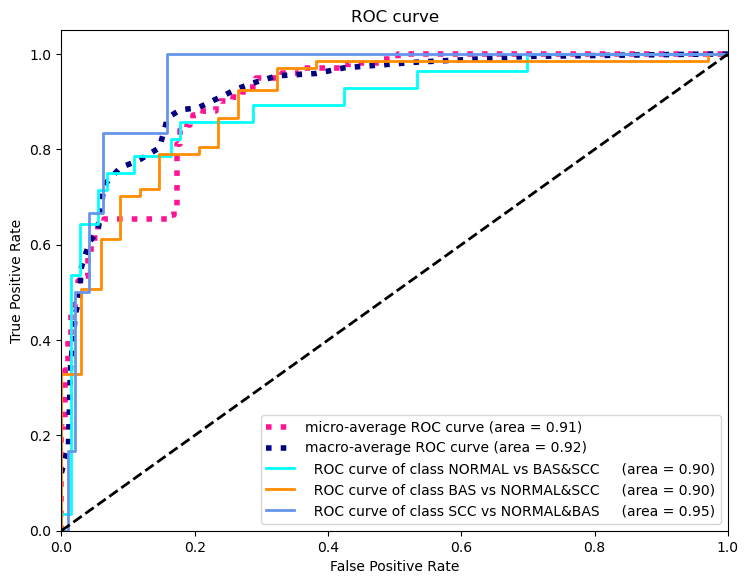

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▁▁▅▆▅▁▁▁▆▁▁▁▆▁▁▇▁▆▁▆▁▁▅▁▁▁▁▁▁▅▁▁▁▁█▇▁▄█▁
Step Train Loss,▁▁▁█▁▁▁▁▁▂▁▁▁▁▁▁▄▁▃▁▁▅▁▁▁▅▁▃ ▁▁▅▃▁▁▁▁▄▁▁
Val loss,█▁
Weighted Balanced Accuracy,▁▁
Accuracy,0.66337


wandb: Agent Starting Run: tx5d4kmw with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 547
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 69
wandb: 	w1: 51
wandb: 	w2: 14
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


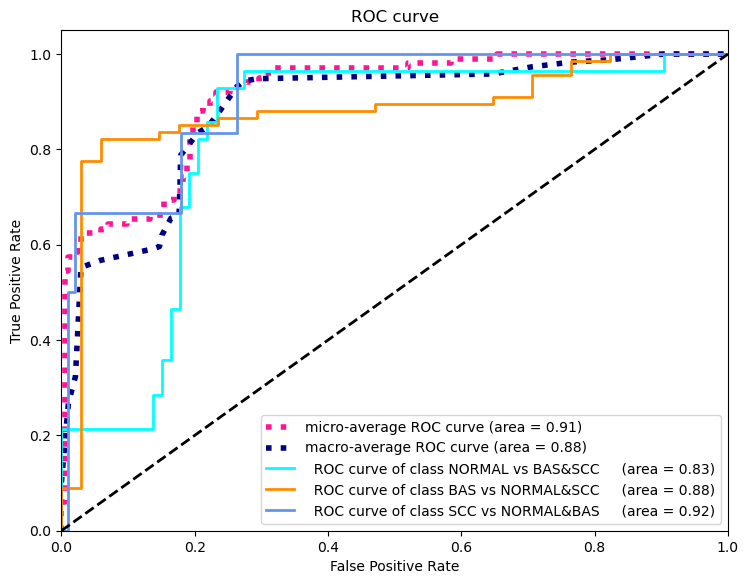

Accuracy,▁█
Balanced Accuracy,▁█
Cohen Kappa,▁█
F1_macro,▁█
F1_micro,▁█
MCC,▁█
Step Test Loss,▆▁▁▁▁▁▁▁▁█▁▆▆▁▁▁▆▁▁▆▁▁▁▁▁▁▂▃▃▁▁▁▁▁▄▁▁▁▂▄
Step Train Loss,▁▁▁▁▁▁▂▁▁▁▁▆▁▇▂▁▁▁█▁▁▂▁▁▁▃▁▄▃▁▃▁▁▁▁▁▅▃▁▄
Train Loss,▁
Val loss,█▁
Weighted Balanced Accuracy,▁█


wandb: Agent Starting Run: wdvhqrq8 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 434
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 3
wandb: 	w1: 93
wandb: 	w2: 26
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


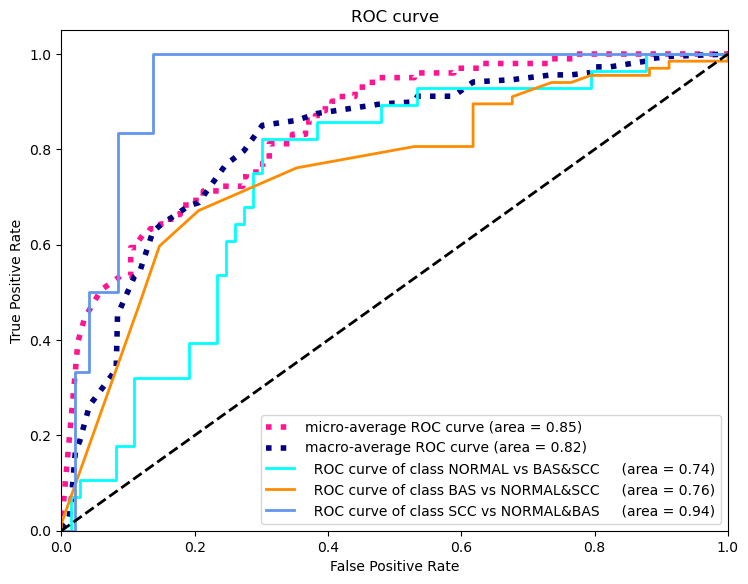

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▇▁▇▇▇█▁▁▇▁▁▁▁▁▁▇▁▁▁▁█▁▁▁▁▁▁▇▁▇▇▁▁▁▁▁▁▁▇▁
Step Train Loss,▅▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁
Val loss,█▁
Weighted Balanced Accuracy,▁▁


wandb: Agent Starting Run: anz8juj5 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 142
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 11
wandb: 	w1: 29
wandb: 	w2: 5
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


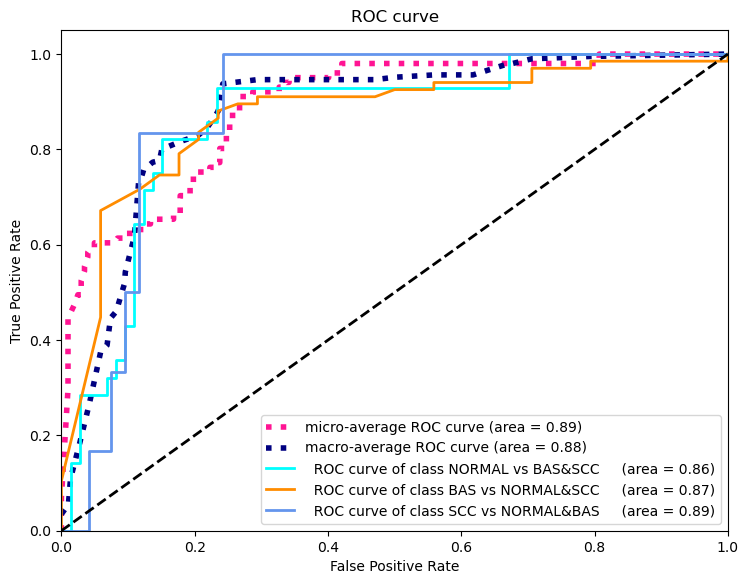

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▇▁██▁▁▇▁▁▁▁█▁█▁█▇█▁▁▆▆▁▁▄▁▁▁▁▅▆▁▅▆▁▁▅▁▁▅
Step Train Loss,▁▁▃▁▁▁▁▁▄▄▁▁▁▁█▁▁▁▂▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▁
Val loss,█▁
Weighted Balanced Accuracy,▁▁


wandb: Agent Starting Run: knvw3smb with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 549
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 28
wandb: 	w1: 42
wandb: 	w2: 80
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


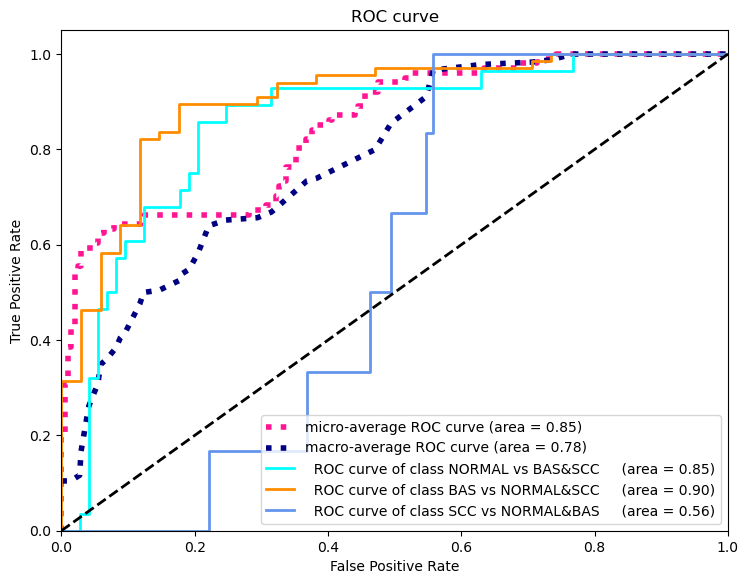

Accuracy,▁█
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁█
F1_micro,▁█
MCC,▁▁
Step Test Loss,▄▁▄▃▃▂▃▂▁▃▃▂▁█▂▃▂▂▄█▁▁▁▃▁▁▁▃▃▁▄▄▄▁▁▁▅▁▁▄
Step Train Loss,▂█▁▁▁▁▄▁▁▁▁▁▁▁▁▁▄▁▁▃▁▁▆▂▄▁▄▁▁▄▁▆▄▂▁▃▁▃▁▁
Val loss,█▁
Weighted Balanced Accuracy,▁▁
Accuracy,0.66337


wandb: Agent Starting Run: pm9jrss4 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 597
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 59
wandb: 	w1: 10
wandb: 	w2: 12
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


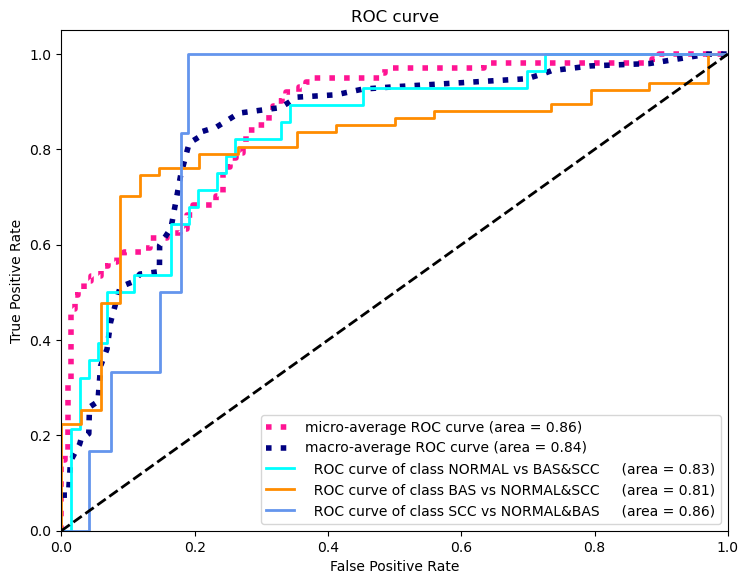

Accuracy,█▁
Balanced Accuracy,▁█
Cohen Kappa,▁█
F1_macro,▁█
F1_micro,█▁
MCC,▁█
Step Test Loss,▁▇▁▁▁▆▁▁▁▁█▁▆▁▁▁▁▁█▁▁▂▄▁▆▁▁▆▃▃▁▃▅▁▅▁▁▁▁▅
Step Train Loss,▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,█▁
Weighted Balanced Accuracy,▁█
Accuracy,0.63366


wandb: Agent Starting Run: ajtinqyp with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 73
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 13
wandb: 	w1: 98
wandb: 	w2: 38
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


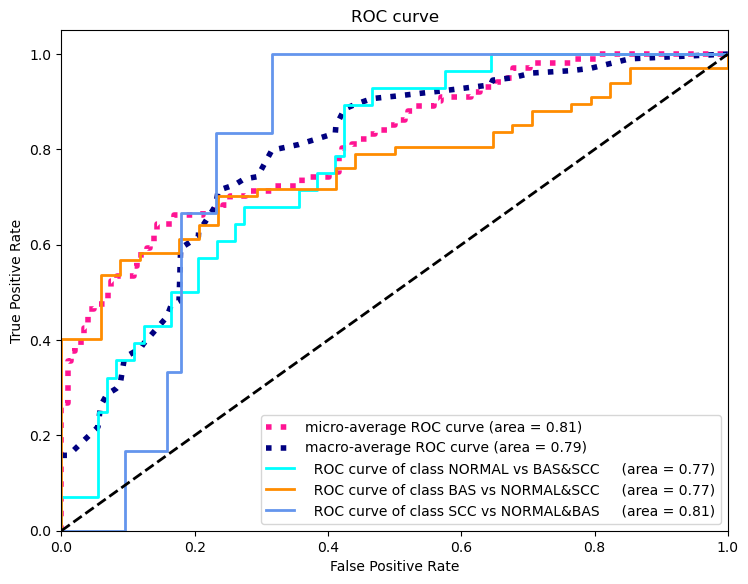

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▁█▁▄▁▁▁▄▁▁▄▄█▁▁█▄▁▅▁▁▅▁▁▄▁▁▁▁▁▄▄▁▁▁▁▁▁▄▁
Step Train Loss,▁█▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁
Train Loss,█▁
Val loss,█▁
Weighted Balanced Accuracy,▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bb5fxykw with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 114
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 21
wandb: 	w1: 82
wandb: 	w2: 29
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


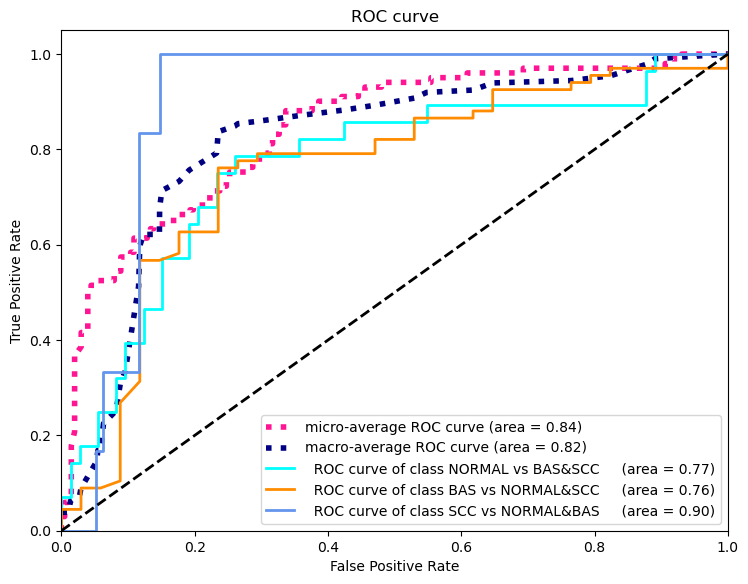

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
Step Train Loss,▁▁▆▁▁▁▁▁▁▁▁▁▁▁▄▁▁█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁
Val loss,▁█
Weighted Balanced Accuracy,▁▁


wandb: Agent Starting Run: whj2b43r with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 290
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 46
wandb: 	w1: 97
wandb: 	w2: 70
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


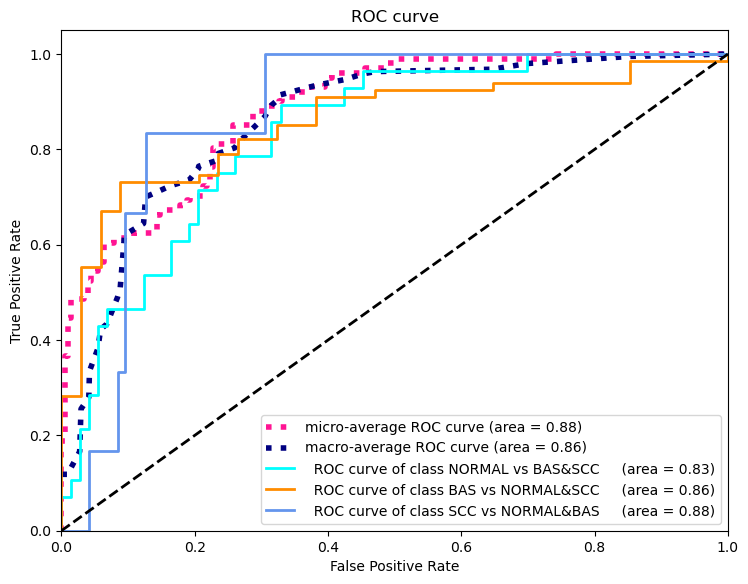

Accuracy,▁█
Balanced Accuracy,▁█
Cohen Kappa,▁█
F1_macro,▁█
F1_micro,▁█
MCC,▁█
Step Test Loss,▁██▁▅▁▁▁▁▁▁▁▁▁▁▇▇▁▁▇▁▃▁▁▁▁▁▄▃▁▃▄▁▁▁▁▁▁▃▁
Step Train Loss,▁▁▁▃▁▁▁▁▁▁▁▁▇▁▇▁▁▁▁▁█▁▁▁▁▁▃▆▁▁▁▁▁▃▁▁▁▁▁▁
Val loss,█▁
Weighted Balanced Accuracy,▁█
Accuracy,0.67327


wandb: Agent Starting Run: fq3eg4y0 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 299
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 76
wandb: 	w1: 96
wandb: 	w2: 17
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


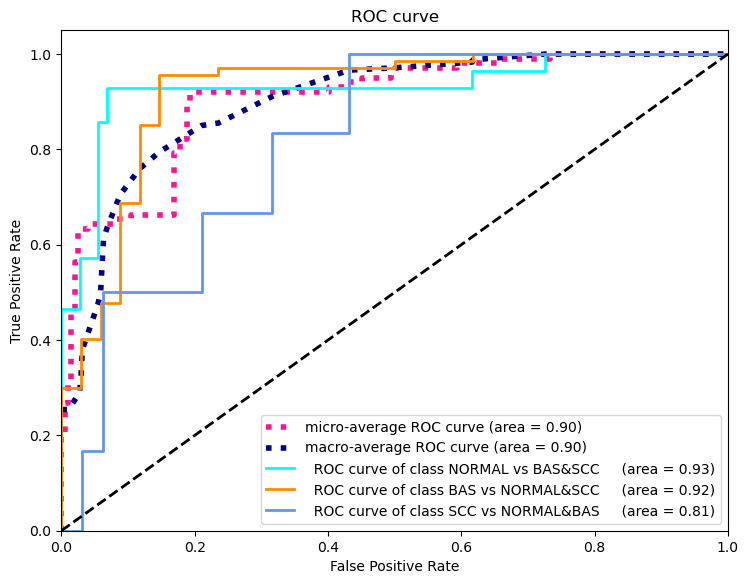

Accuracy,▁▁
Balanced Accuracy,▁▁
Cohen Kappa,▁▁
F1_macro,▁▁
F1_micro,▁▁
MCC,▁▁
Step Test Loss,▁▁▃▁▁▁▂█▁▃▁▁▁▃▁▁█▃▂▃▁▁▁▁▅▅▁▁▁▁▁▁▁▅▁▁▅▁▁▆
Step Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val loss,▁█
Weighted Balanced Accuracy,▁▁
Accuracy,0.66337


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ry4kjg3o with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 196
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 61
wandb: 	w1: 95
wandb: 	w2: 76
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


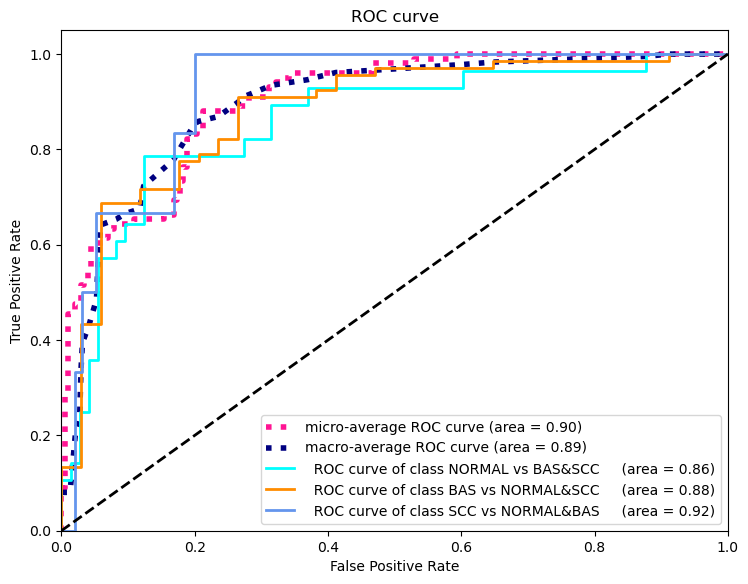

Accuracy,█▁
Balanced Accuracy,█▁
Cohen Kappa,█▁
F1_macro,█▁
F1_micro,█▁
MCC,█▁
Step Test Loss,▁▁▁▁▁▂▁▃▃▁▆▁▁▁▁▃▁▁▃▁█▃▁▁▃▆▃▁▃▁▁▂▁▁▁▃▁▆▄▁
Step Train Loss,▁▁▁▇▁▅▁█▃▁▁▁▅▁▂▁▁▁▁▁▆▁▁▄▂▅▃▁▄▃▂▃▁▂▁▁▄▁▄▁
Val loss,▁█
Weighted Balanced Accuracy,█▁
Accuracy,0.66337


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xk51reg1 with config:
wandb: 	alpha: 0.849435264741892
wandb: 	batch_size: 310
wandb: 	betas: [0.5, 0.999]
wandb: 	classes: 3
wandb: 	dataset: CNT_VIG
wandb: 	device: cuda:0
wandb: 	df: df_combined
wandb: 	dropout: 0.3
wandb: 	epochs: 2
wandb: 	grad_norm_clip: 1.02580285460309
wandb: 	in_size: 2000
wandb: 	lr: 0.0203373691328209
wandb: 	minlr: 5e-06
wandb: 	momentum: 0.9
wandb: 	optimizer: SGD
wandb: 	out_size: 3
wandb: 	scheduler: cosine
wandb: 	sd: 69858
wandb: 	split: random
wandb: 	w0: 99
wandb: 	w1: 89
wandb: 	w2: 72
wandb: 	weight_decay: 0.0001
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Epoch 1


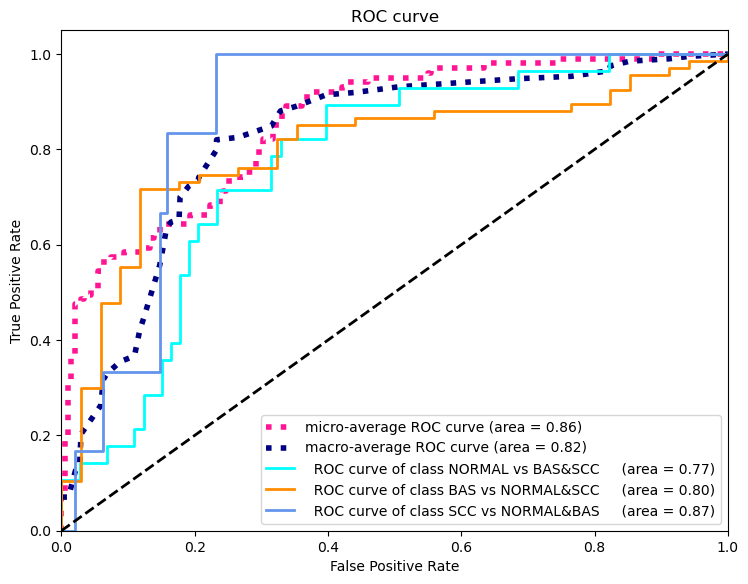

Accuracy,█▁
Balanced Accuracy,▁█
Cohen Kappa,█▁
F1_macro,▁█
F1_micro,█▁
MCC,█▁
Step Test Loss,▂▂▁▂▁▂▁█▁▁▂▁█▁▁▁▂▃▁▁▁▆▁▅█▁▂▆▁▁▁▁▁▁▂▃▁▁▆▁
Step Train Loss,▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁
Val loss,▁█
Weighted Balanced Accuracy,▁█


In [23]:
wandb.agent(sweep_id, train, count=12)

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Epoch 0
Threshold: [array([1.9797093 , 0.97970927, 0.9714267 , 0.97075474, 0.96788687,
       0.965797  , 0.9596155 , 0.9595138 , 0.9579681 , 0.95774263,
       0.9571521 , 0.9542452 , 0.9538714 , 0.95326483, 0.9526144 ,
       0.95235026, 0.94768226, 0.947079  , 0.9447376 , 0.9441571 ,
       0.9428643 , 0.9413467 , 0.9370218 , 0.9319437 , 0.9300291 ,
       0.9298376 , 0.9257341 , 0.9254225 , 0.9240669 , 0.92371523,
       0.91718334, 0.9130774 , 0.90693915, 0.9036746 , 0.9036544 ,
       0.8982539 , 0.8977711 , 0.8973061 , 0.8897689 , 0.88696903,
       0.8842779 , 0.8815736 , 0.8808318 , 0.8730302 , 0.8583518 ,
       0.8531384 , 0.8493359 , 0.84441614, 0.3191893 ], dtype=float32), array([1.6601985 , 0.66019845, 0.11344558, 0.11320022, 0.05764873,
       0.05737334, 0.04386602, 0.04336413, 0.03928716, 0.03923107,
       0.03824739, 0.03815589, 0.03712207, 0.03619726, 0.03580247,
       0.03525701, 0.03422661, 0.0319744 , 0.03058983, 0.03046444,
       0.02875261, 0.02857479, 0.0265

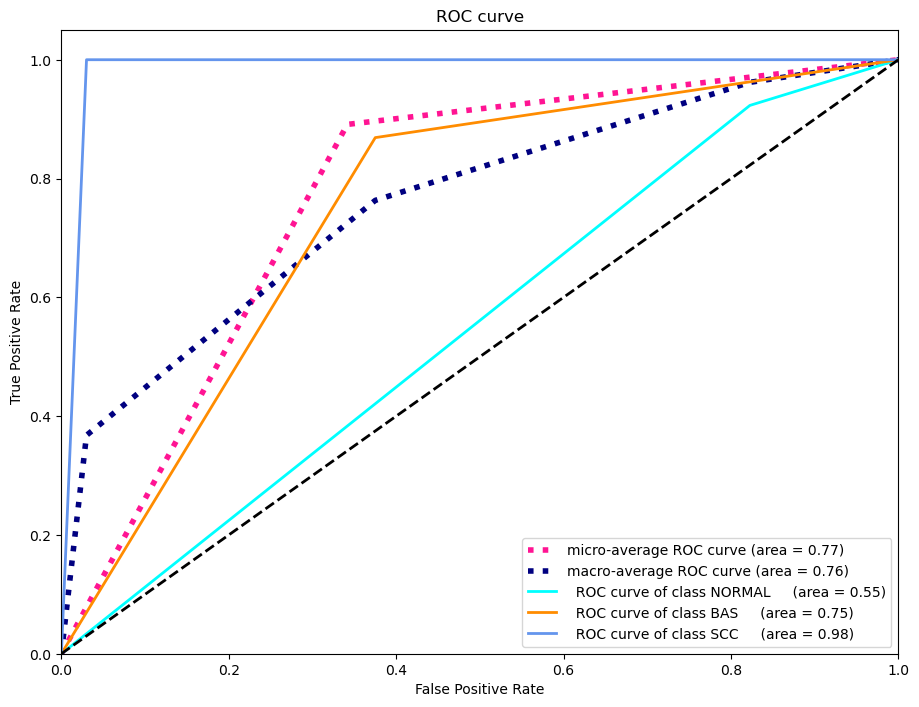

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 1.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 1. 0.]
 [1. 0. 0.]
 [1. 1. 0.]
 [1.

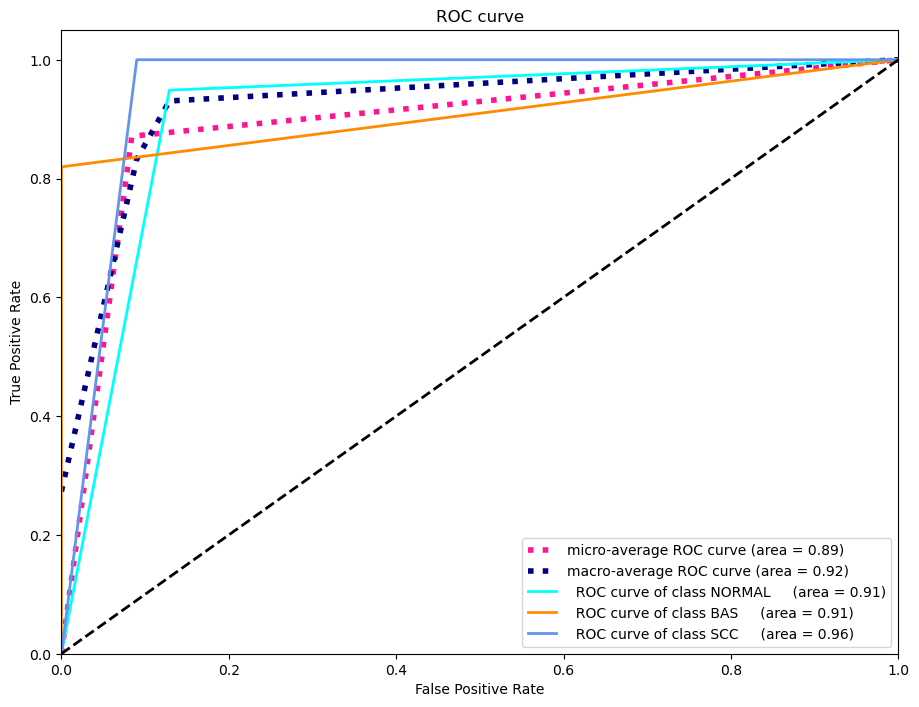

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1.

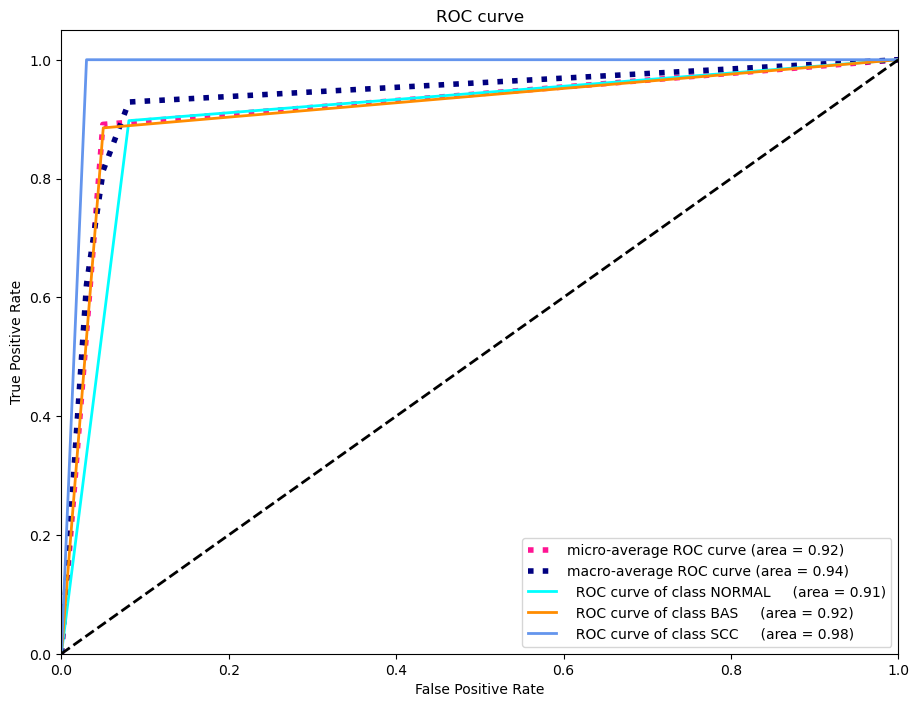

prediction: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1.

In [21]:
train(config)

Epoch 0


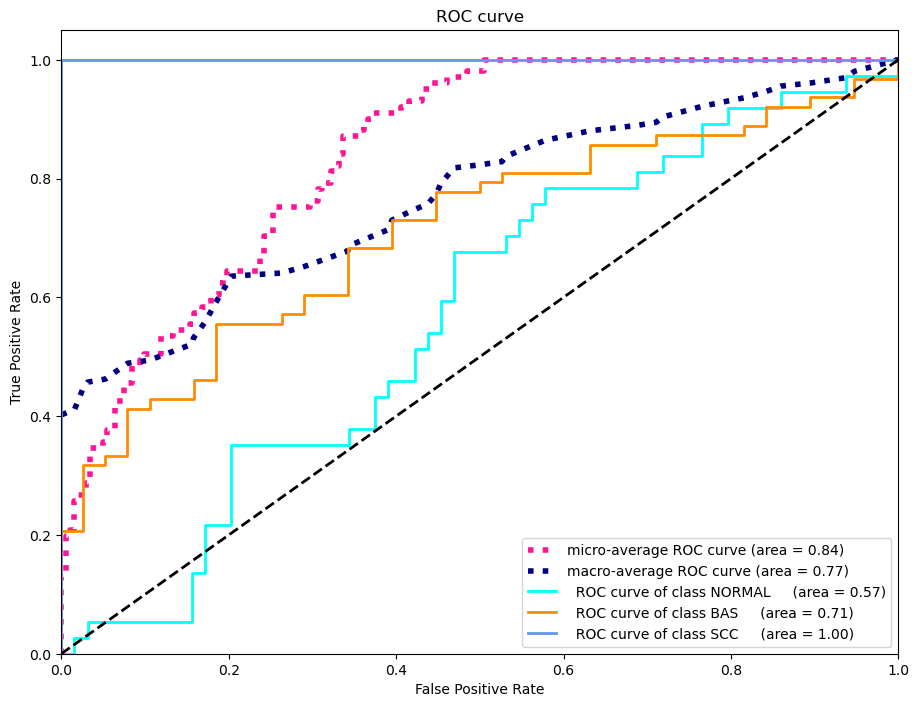

Epoch 1


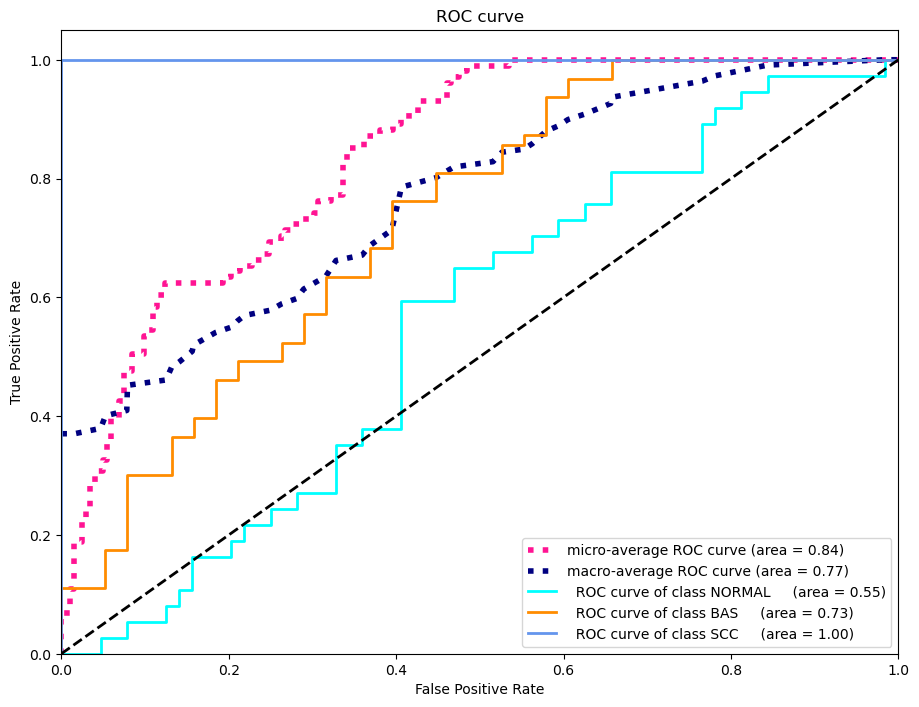

Epoch 2


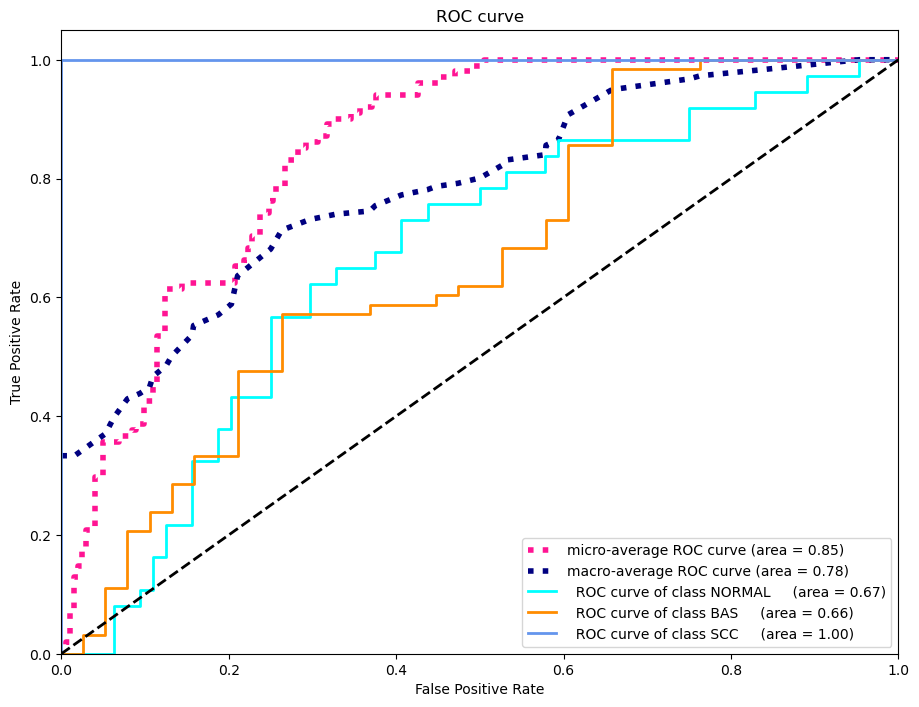

Epoch 3


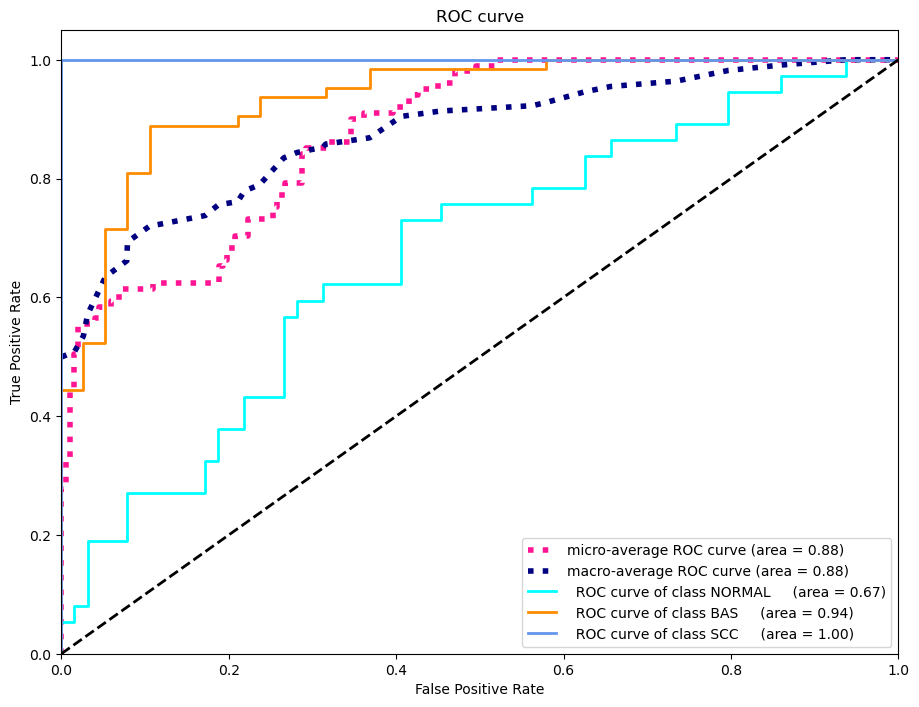

Epoch 4


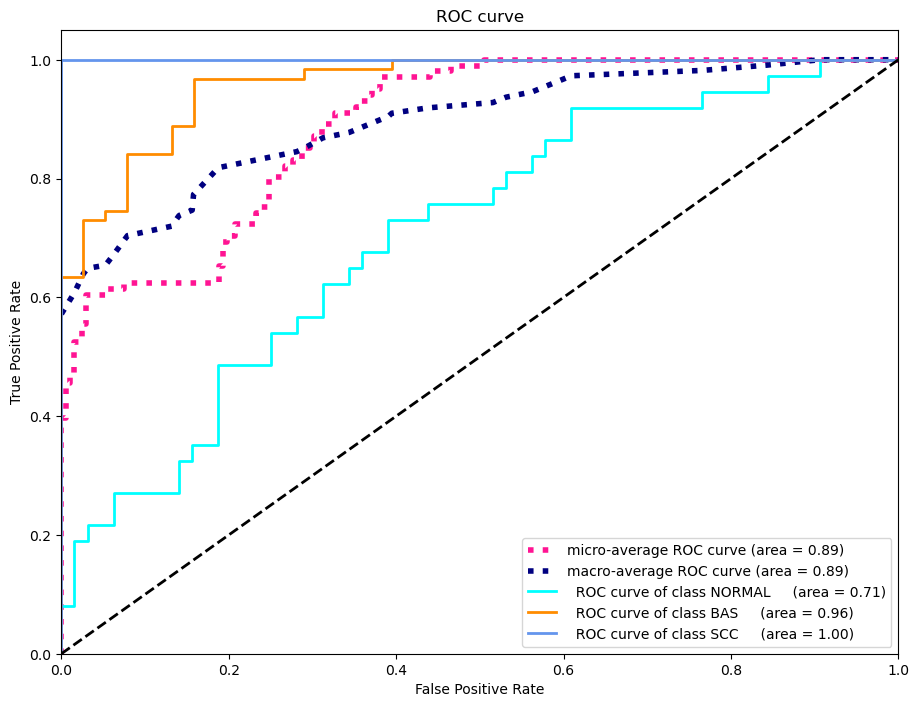

Epoch 5


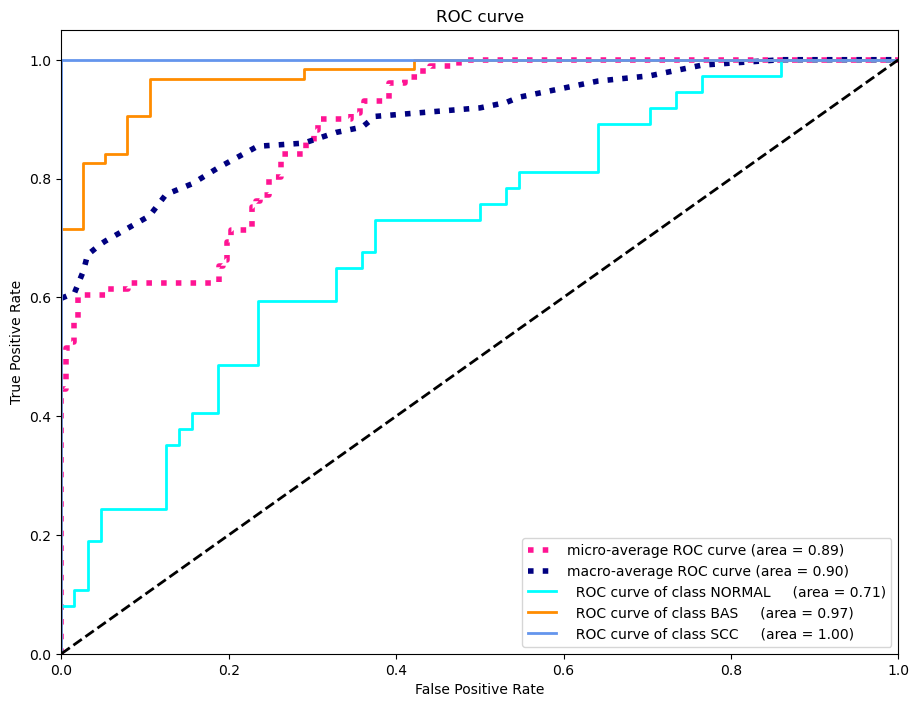

Epoch 6


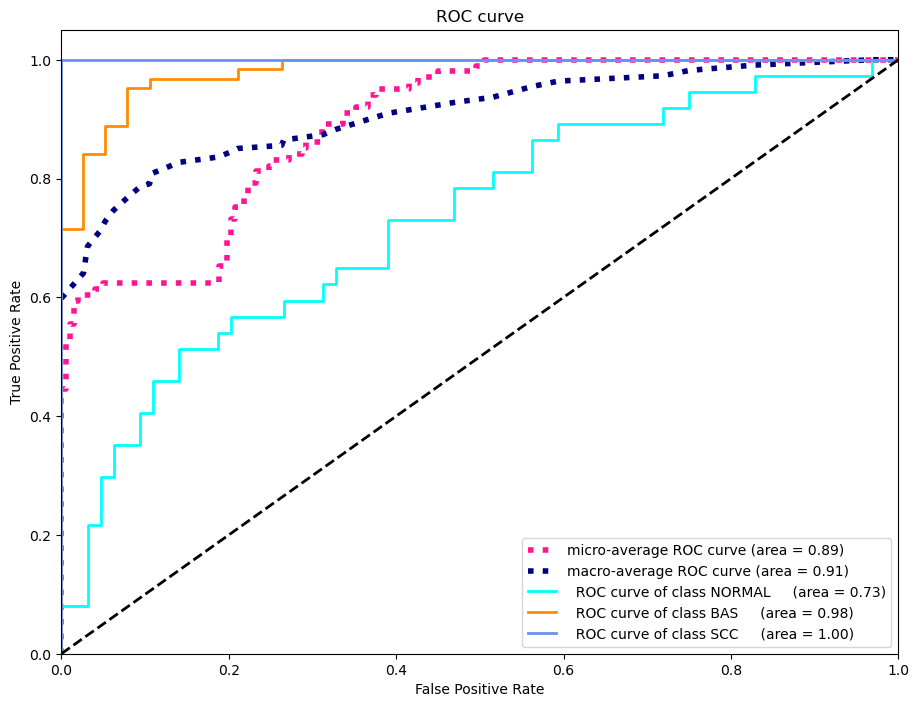

Epoch 7


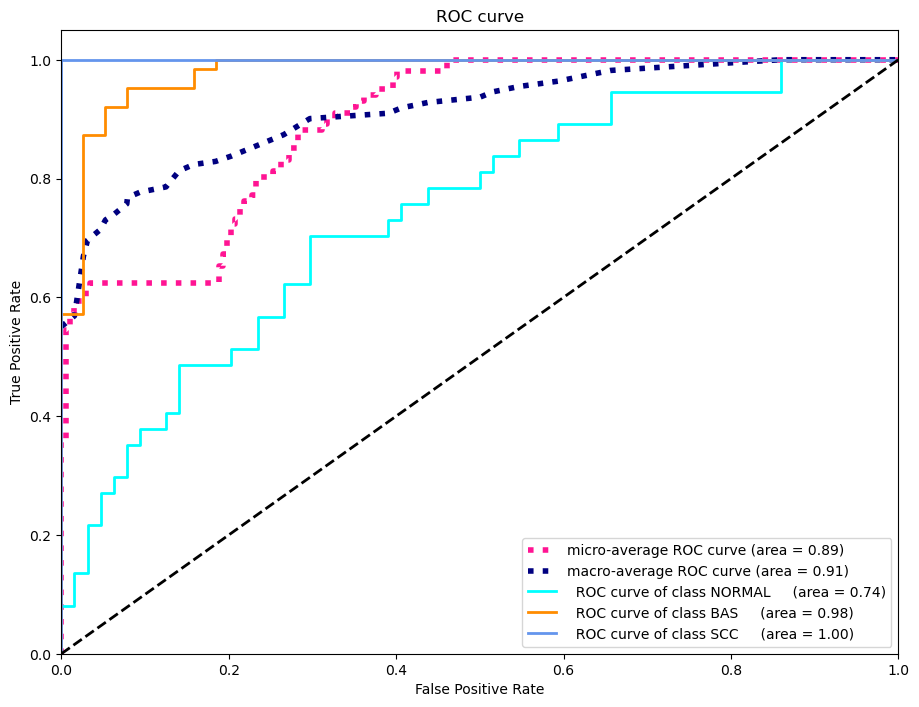

Epoch 8


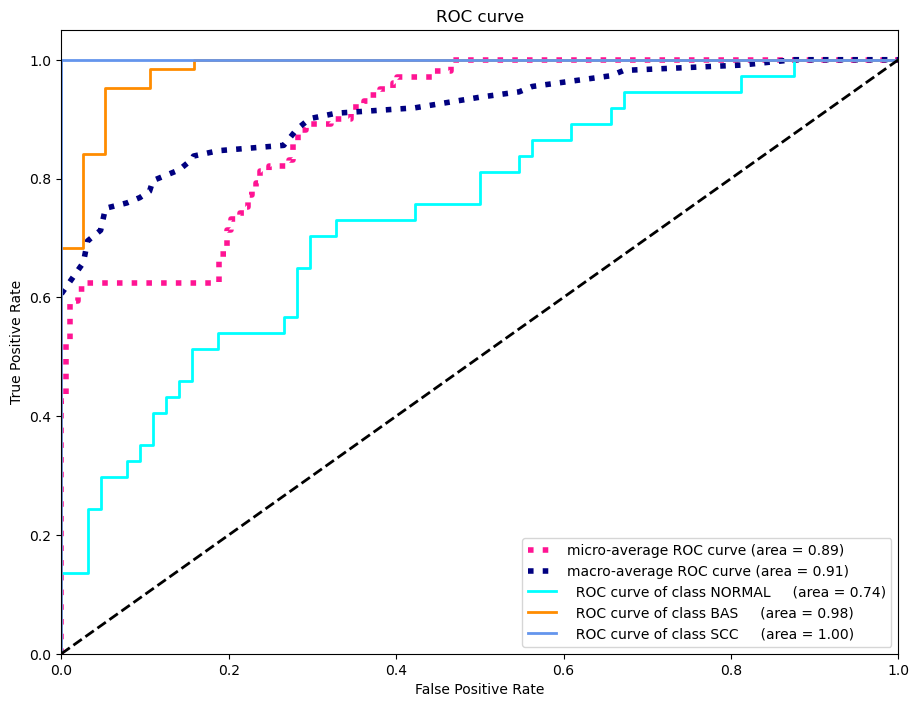

Epoch 9


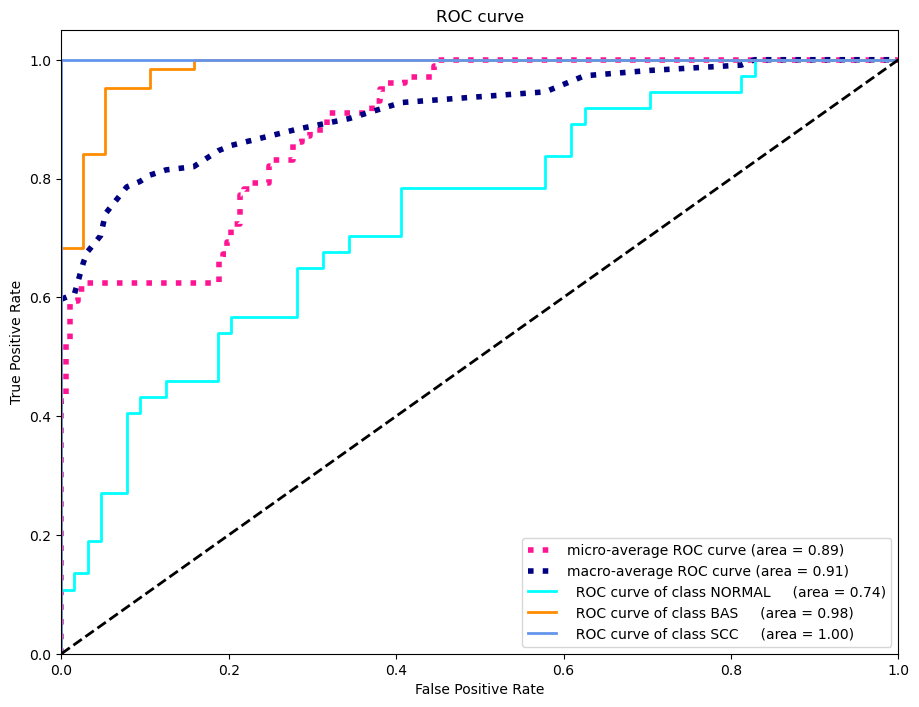

Epoch 10


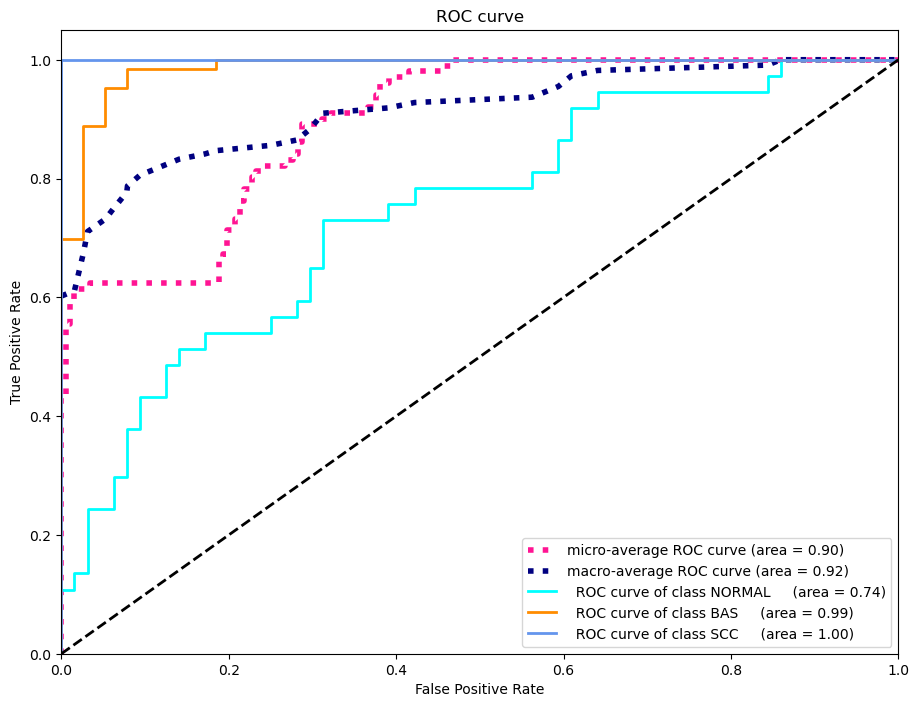

Epoch 11


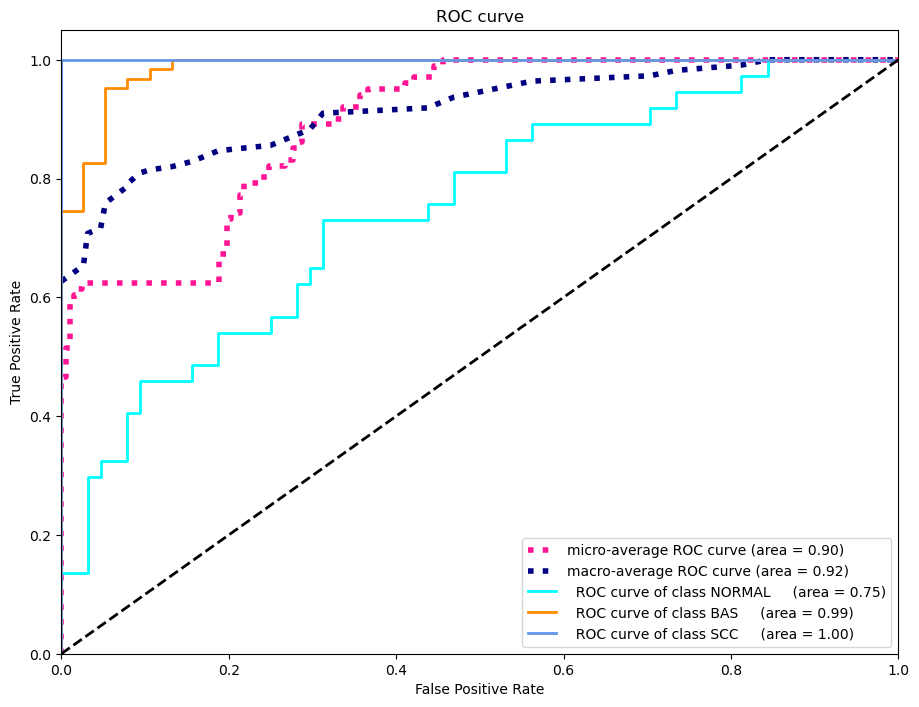

Epoch 12


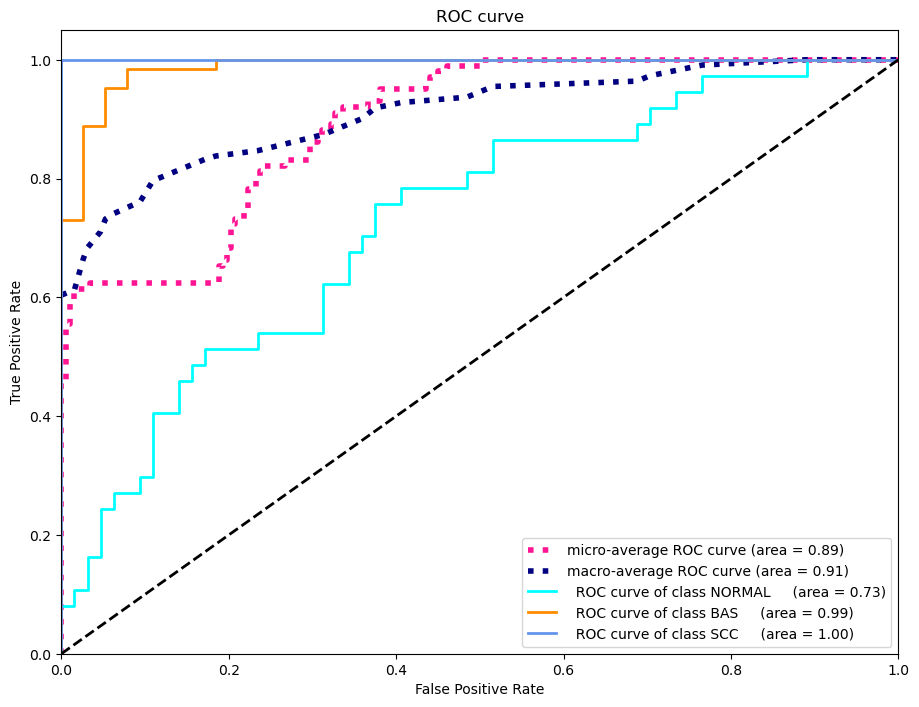

Epoch 13


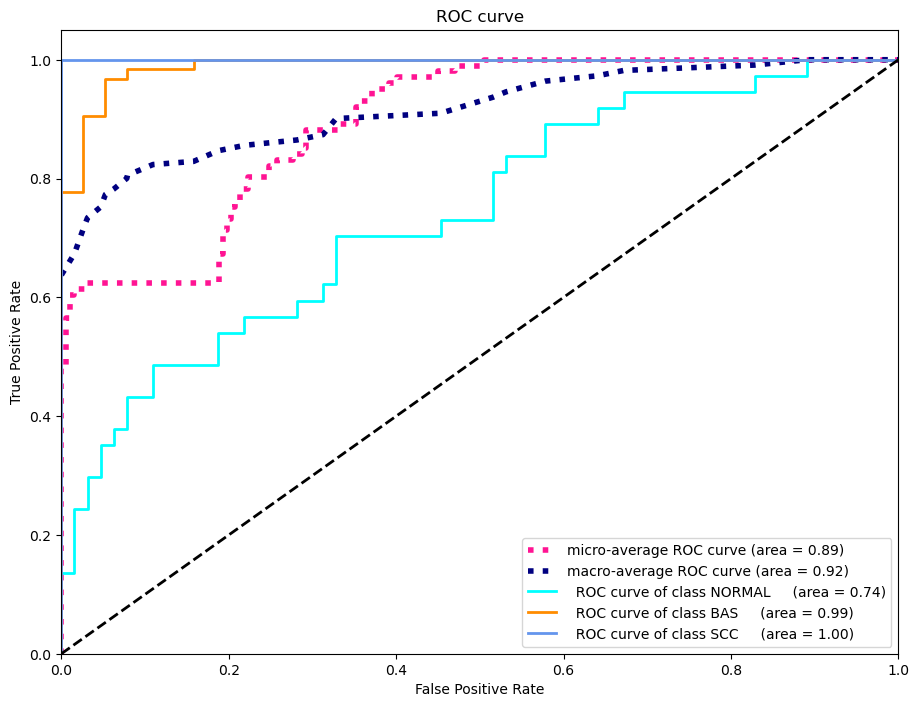

Epoch 14


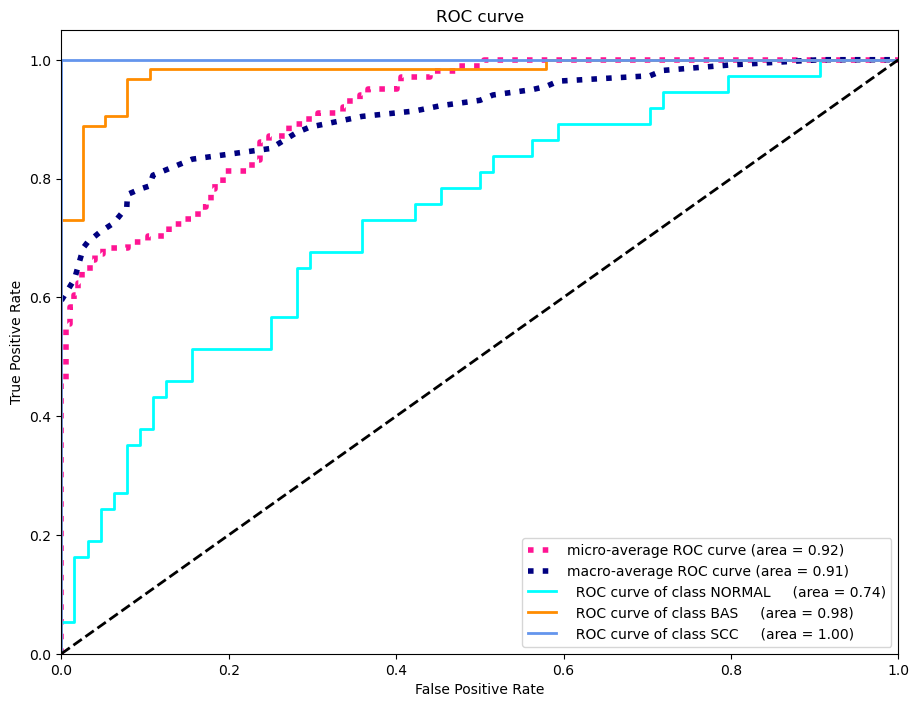

Epoch 15


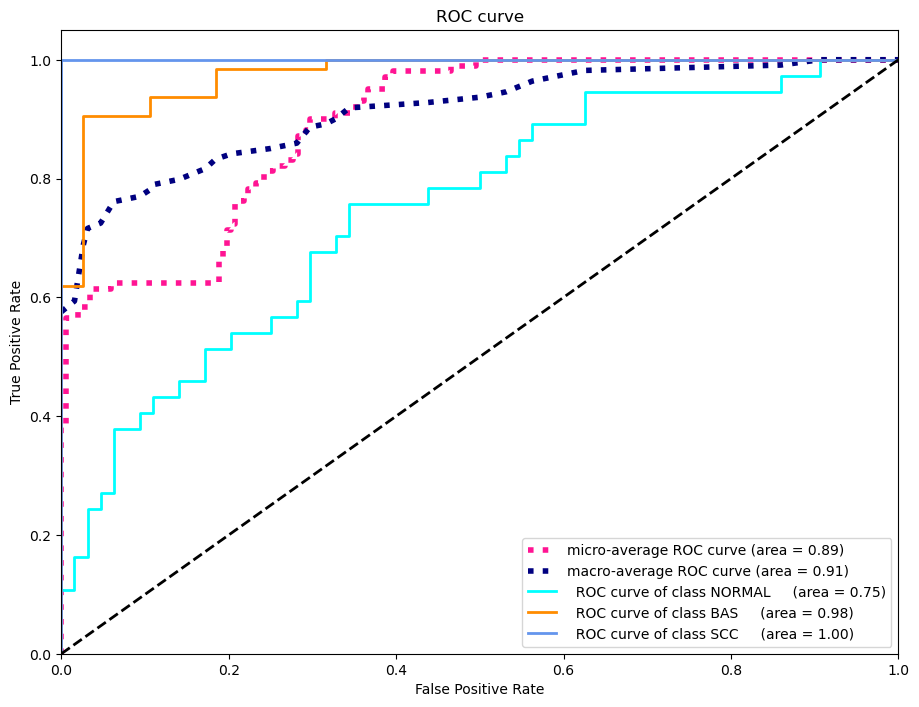

Epoch 16


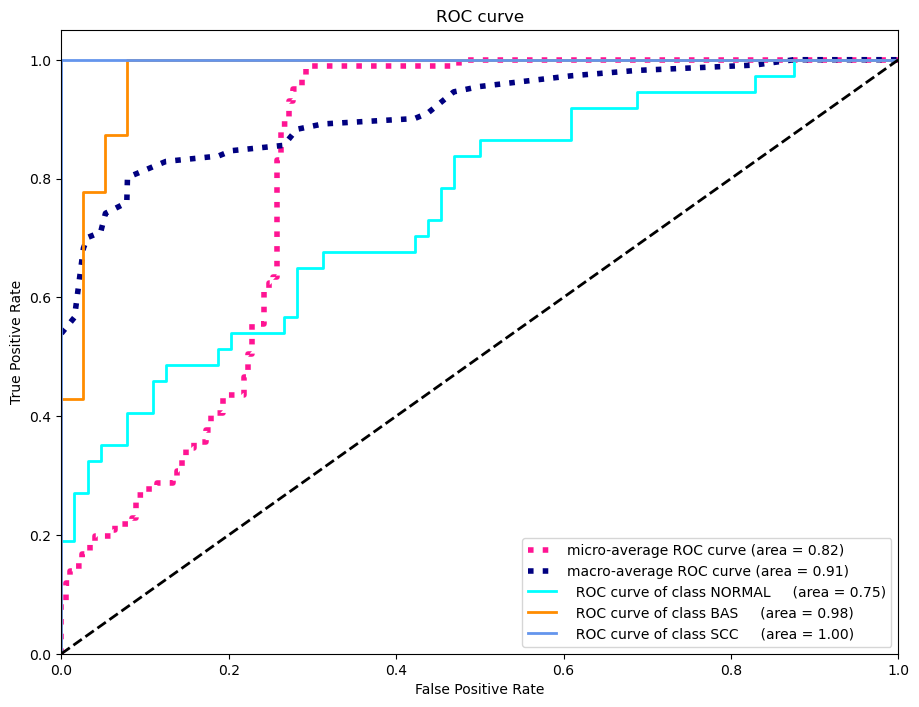

Epoch 17


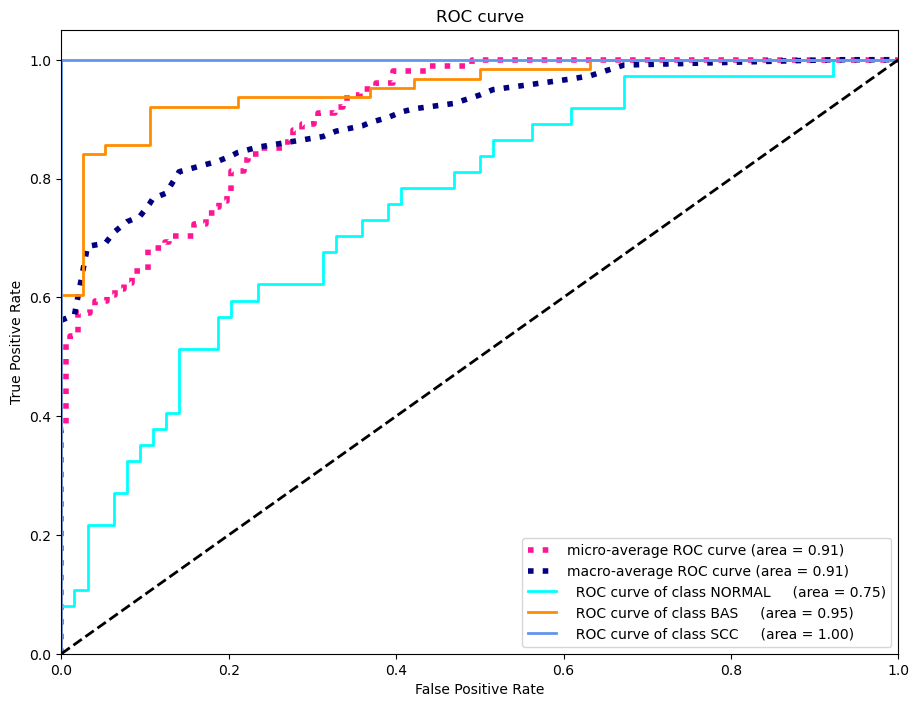

Epoch 18


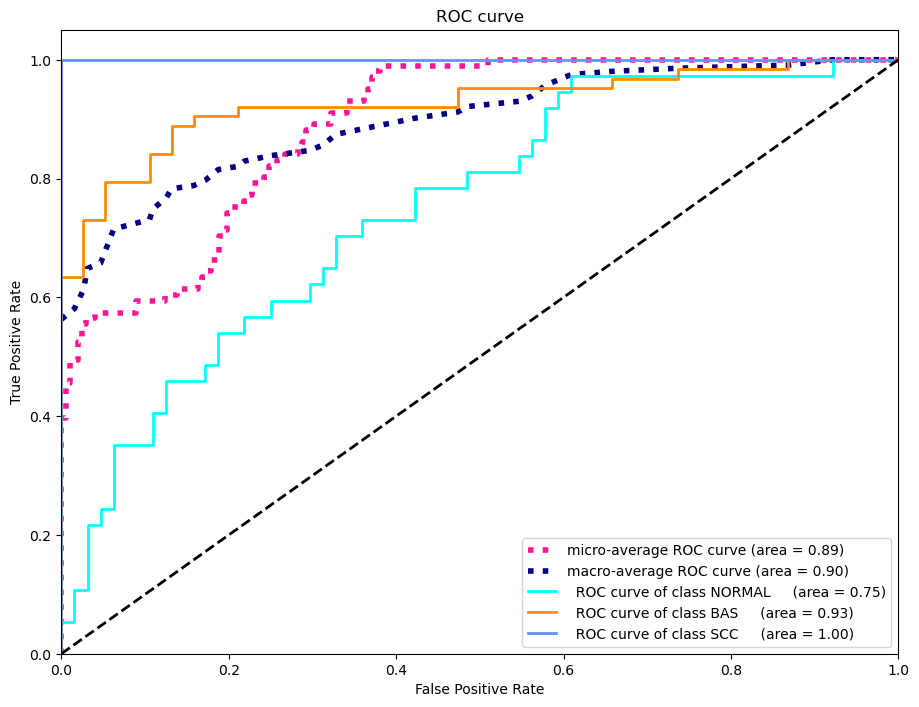

Epoch 19


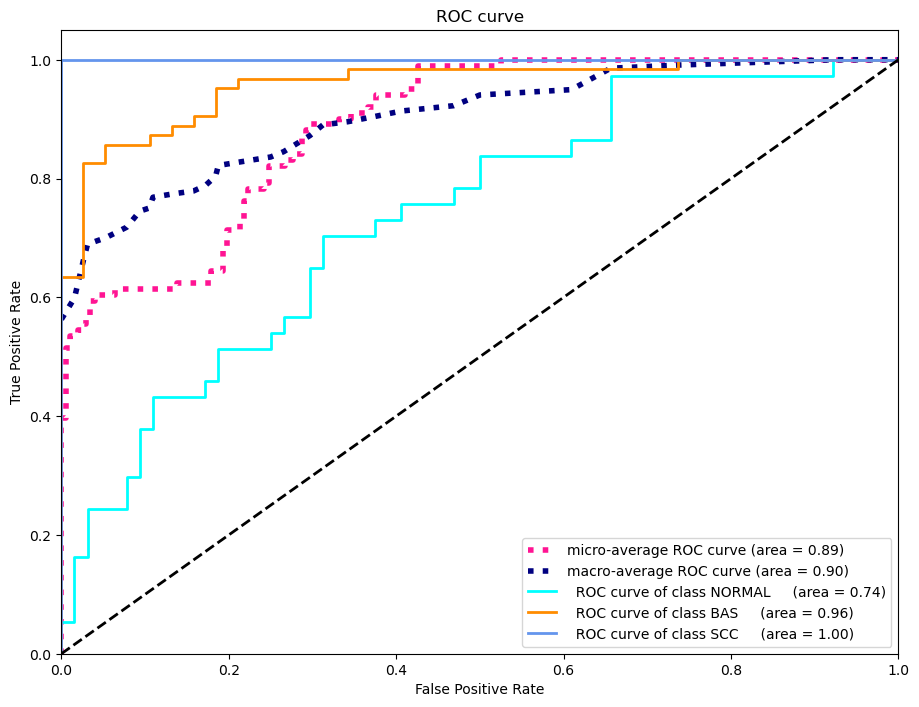

Epoch 20


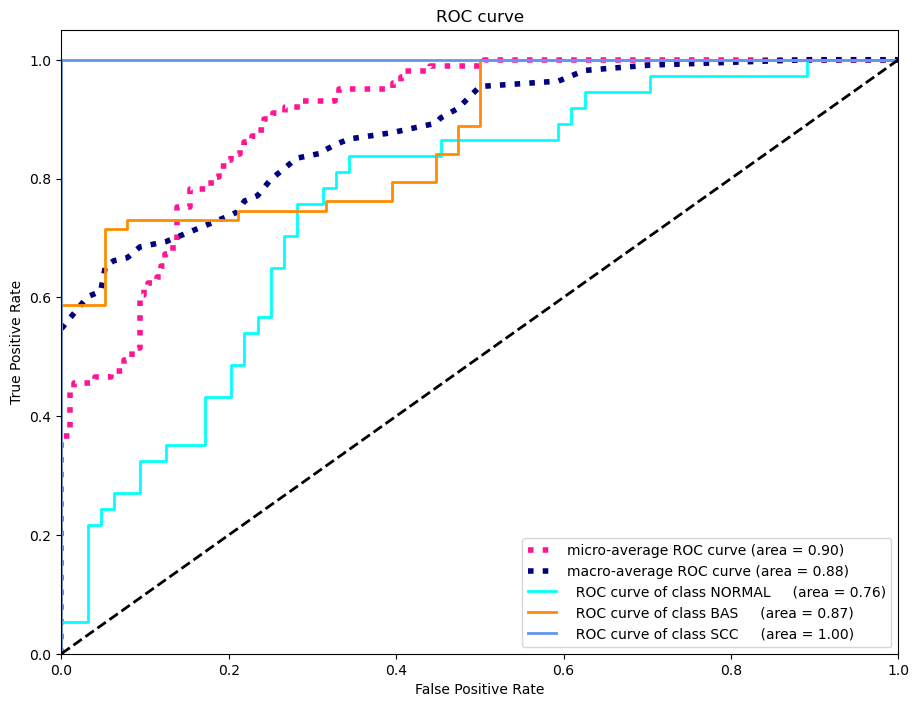

Epoch 21


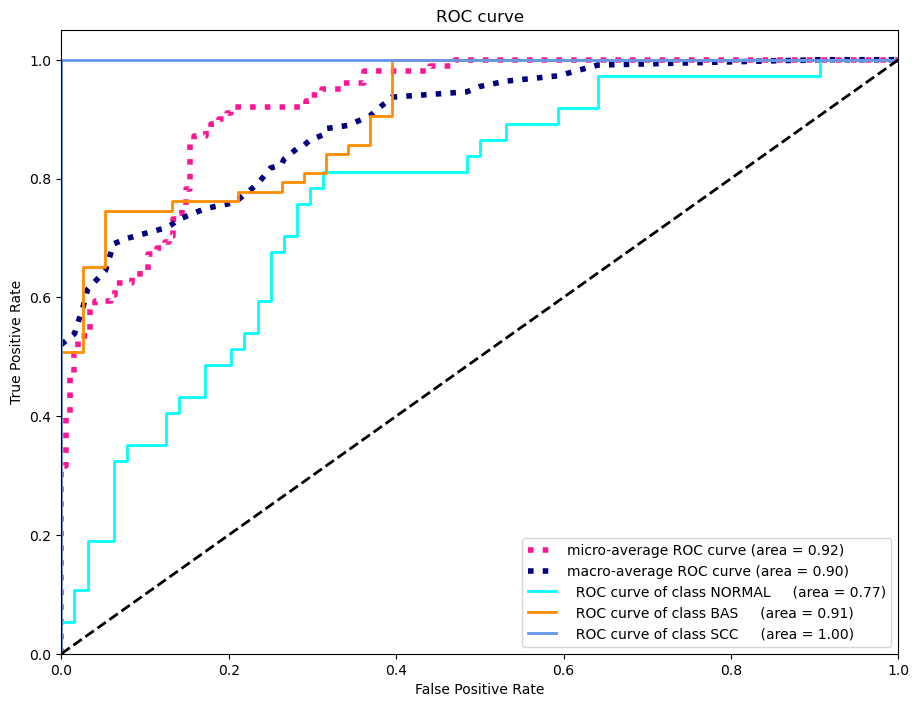

Epoch 22


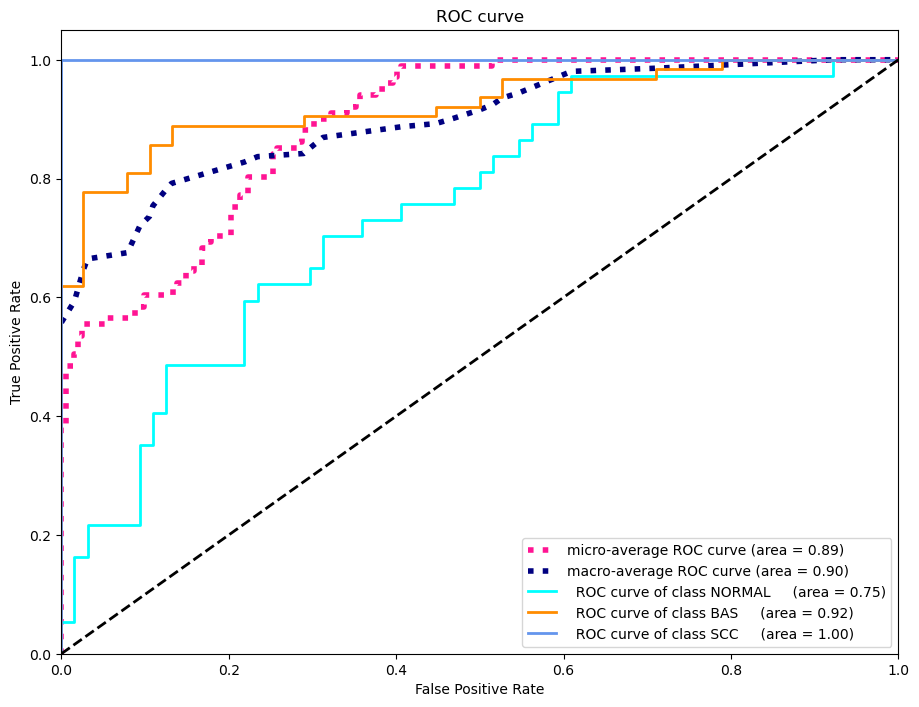

Epoch 23


In [67]:

train(config)